I need to clean up this code a bit - and implement PAL.  Why not do both in one go?

In [1]:
# Just your usual setup

import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fdls
import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# It's optimal if this is a power of 2.  
# For CPU use 16K appears best, but it looks like a lot of samples need to be cut for audio
blocklenk = 32
blocklen = (blocklenk * 1024)

# This may be higher than necessary at this point...
blockcut = 1536

In [3]:
# charting/graphing code carried over from earlier development efforts
# (will probably be moved back into a ldutils2 package)

def dbify(y):
    db = 20 * np.log10(np.abs(y))
    return db - np.max(db)

def reallydoplot(w, h, freq, zero_base = False):
    db = 20 * np.log10(abs(h))
    if zero_base:
        db -= np.max(db)

    above_m3 = None
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i]) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i])
            above_m3 = i
        if (db[i] < -3) and (db[i - 1] >= -3):
            if above_m3 is not None:
                peak_index = np.argmax(db[above_m3:i]) + above_m3
                print("peak at ", w[peak_index], db[peak_index])
            print("<-3db crossing at ", w[i]) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i]) 
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, db, 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

def doplot(B, A, freq = 40, whole = False, zero_base = False):
    w, h = sps.freqz(B, A, whole = whole, worN=4096)
    if whole:
        w = np.arange(0, freq, freq / len(h))
    else:
        w = np.arange(0, (freq / 2), (freq / 2) / len(h))
        
    return reallydoplot(w, h, freq, zero_base)

def plotfilt(filterset, key, power = 1.0, extra = None):
    # take the first half of the FFT multiplier
    h = filterset[key] ** power
    h = h[0:len(h)//2]
    
    freq = filterset['freq'] / 2
    w = np.arange(0, freq, freq / len(h))

    return reallydoplot(w, h, freq)

# Draws a uint16 image, downscaled to uint8
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

# IEC 60857 9.2.2: the range from -40 to 100 IRE is 1.7mhz, with 0 at 8.1mhz.  Maximum is 110IRE.
NTSC_hz_ire = 1700000 / 140.0

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'pilot_mhz': (315.0 / 88.0),
    
    'line_period': 63.5, # in usecs,
    'frame_lines': 525,

    # video frequencies 
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000+(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # This matches 'old' ld-decode so the comb filter works correctly
    'ire_min': -60,
    'ire_max': 140,
    'output_irescale': 65534.0 / (140 - -60),

    'syncrange': (-55, -25),
    
    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    # (note:  i don't know how to handle these values perfectly yet!)
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters are important with DD v3.0+ boards
    'audio_filtwidth': 350000,
    'audio_filtorder': 2,

    # This BPF similar but not *quite* identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz or even a bit higher. 
    # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'pilot_mhz': 3.75,
    
    'line_period': 64, # in usecs
    'frame_lines': 625,
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on PAL LD this includes a very strong pilot signal
    
    # The PAL spec does not use IRE but rather voltage.  
    # This code uses IRE anyway, so :P
    'videorf_0ire': 7100000, # the sync signal peaks about here at full saturation
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,
    
    'syncrange': (-50, -20),

    # changeable defaults
    'analog_audio': True, # not true for later PAL

    'deemp': (100*.32, 400*.32),

    # The audio notch filters are important with DD v3.0+ boards
    'audio_filtwidth': 350000,
    'audio_filtorder': 2,

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order
}


In [5]:
# Load up default parameters

params = {'freq': 40, 'blocklen': blocklen}

for p in [SysParams_PAL]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]

# a few things that are best declared outside the dict
hz_ire_scale = (params['videorf_100ire'] - params['videorf_0ire']) / 100.0
params['hz_ire'] = hz_ire_scale

# analog filter parameters presumed to be equivalent for PAL and NTSC
params['audio1_filtlen'] = 800
params['audio1_passwidth'] = 150000

In [6]:
params['linelen_4fsc'] = int(np.round(((params['fsc_mhz'] * 1000000) * 4) * (params['line_period'] / 1000000)))
params['linelen_pilot'] = int(np.round(((params['pilot_mhz'] * 1000000) * 4) * (params['line_period'] / 1000000)))

In [7]:
params['linelen_pilot']

960

In [8]:
#https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
polar2z = lambda r,θ: r * np.exp( 1j * θ )
deg2rad = lambda θ: θ * (np.pi / 180)

In [9]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

# crude zero-crossing calculator.

hz0ire = params['videorf_0ire']

def iretohz(ire):
    return hz0ire + (hz_ire_scale * ire)

def hztoire(hz):
    return (hz - hz0ire) / hz_ire_scale

m20ire = iretohz(-20)

def calczc(data, _start_offset, target, edge='both', reverse=False, _count=10):
    start_offset = int(_start_offset)
    count = int(_count + 1)
    
    if edge == 'both': # capture rising or falling edge
        if data[start_offset] < target:
            edge = 'rising'
        else:
            edge = 'falling'

    if edge == 'rising':
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
               
    if len(locs) == 0:
        return None

    if reverse:
        index = -1
    else:
        index = 0
        
    x = start_offset + locs[index]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [10]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html

# hilbert_filter_terms has a direct impact on filter offsets.  Emperical testing
# determined that 128 was a good value here.
hilbert_filter_terms = 128
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

# This converts a regular B, A filter to an FFT of our selected block length
def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [33]:
def audio_fdslice(SP, freqdomain):
    return np.concatenate([freqdomain[SP['audio_fdslice_lo']], freqdomain[SP['audio_fdslice_hi']]])

def audio_fdslice2(SP, freqdomain):
    return np.concatenate([freqdomain[SP['audio_fdslice2_lo']], freqdomain[SP['audio_fdslice2_hi']]])

# This prepares the needed transforms to do the actual video decoding
# (and first bit of audio to go along with it)
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    blocklen = params['blocklen']
    
    SP['hilbert_filter_terms'] = hilbert_filter_terms
    
    # build up a couple more constants
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
    
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF filter, which will get the audio notch filters added if needed
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'), blocklen)
    
    # If there is analog audio, it must be filtered well especially with DD >=3.0-beta RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'), blocklen)
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'), blocklen)
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    SP['Fhilbert'] = np.fft.fft(hilbert_filter, blocklen)
    
    # This MTF filter could probably use more work
    if SP['system_name'] == 'NTSC':
        SP['MTF'] = sps.zpk2tf([], [polar2z(.7,np.pi*12.5/20), polar2z(.7,np.pi*27.5/20)], 1.11)
    else: # PAL
        SP['MTF'] = sps.zpk2tf([], [polar2z(.7,np.pi*10/20), polar2z(.7,np.pi*28/20)], 1.11)

    SP['Fmtf'] = filtfft(SP['MTF'], blocklen)
    
    # The above is multiplied with a Hilbert transform to get (partway) to demodulation
    
    # The 4.2-4.6mhz (NTSC)/5.x mhz (PAL) demodulated lowpass filter
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'), blocklen) # standard 4.Xmhz

    # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10), -SP['deemp'][0]*(10**-10), SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half), blocklen)

    # The direct opposite of the above, used in test signal generation
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10), -SP['deemp'][1]*(10**-10), SP['deemp'][1] / SP['deemp'][0])
    SP['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half), blocklen)
    
    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(4, 0.5/freq_half, 'low'), blocklen) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    # Note:  FIR filters cause phase issues for fburst.  A 1-order IIR filter is ideal here.
    if SP['system_name'] == 'NTSC':
        SP['Fburst_len'] = int(np.ceil((18 * freq_half / SP['fsc_mhz']) / 2) * 2)
        SP['Fburst_delay'] = (SP['Fburst_len'] // 4) - 2
        bf = sps.firwin(SP['Fburst_len'] + 1, [(SP['fsc_mhz'] * .975)/freq_half, (SP['fsc_mhz'] * 1.025)/freq_half], pass_zero=False)
        SP['Fburst'] = filtfft((bf, [1.0]), blocklen)
        SP['imglen'] = (int)((SP['freq_hz'] / 59.976) * 1.25)
    else:
        # For PAL this is a 3.75mhz filter
        SP['Fburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        SP['Fburst_delay'] = 24 # for IIR filters this needs to be determined empirically

        SP['imglen'] = (int)((SP['freq_hz'] / 50) * 1.25)
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = [sps.firwin(int((9.4/1000000)*SP['freq_hz'])+1, 0.05/(params['freq'] / 2.0)), [1.0]]
    SP['dgap_sync'] = int((9.4/1000000)*SP['freq_hz']) // 2
    SP['FPsync'] = filtfft(f, blocklen)
    

    # first stage audio filters
    
    audio_fdiv1 = 32 # this is good for 40mhz - 16 should be ideal for 28mhz
    afft_halfwidth = blocklen // (audio_fdiv1 * 2)
    arf_freq = SP['freq_hz'] / (audio_fdiv1 / 2)
    SP['freq_arf'] = arf_freq
    SP['audio_fdiv1'] = audio_fdiv1
    
    SP['audio_cfreq'] = (SP['audio_rfreq'] + SP['audio_lfreq']) // 2
    afft_center = int((SP['audio_cfreq'] / SP['freq_hz']) * (blocklen))

    # beginning and end symmetrical frequency domain slices.  combine to make a cut-down sampling
    afft_start = int(afft_center-afft_halfwidth)
    afft_end = int(afft_center+afft_halfwidth)

    # slice areas for reduced FFT audio demodulation filters
    SP['audio_fdslice_lo'] = slice(afft_start, afft_end)
    SP['audio_fdslice_hi'] = slice(blocklen-afft_end, blocklen-afft_start)

    # compute the base frequency of the cut audio range
    SP['audio_lowfreq'] = SP['audio_cfreq']-(SP['freq_hz']/(2*SP['audio_fdiv1']))
    
    afilt_left = filtfft([sps.firwin(SP['audio1_filtlen'], [(SP['audio_lfreq']-SP['audio1_passwidth'])/freq_hz_half, (SP['audio_lfreq']+SP['audio1_passwidth'])/freq_hz_half], pass_zero=False), 1.0])
    SP['audio_lfilt'] = audio_fdslice(SP, afilt_left * SP['Fhilbert']) 
    afilt_right = filtfft([sps.firwin(SP['audio1_filtlen'], [(SP['audio_rfreq']-SP['audio1_passwidth'])/freq_hz_half, (SP['audio_rfreq']+SP['audio1_passwidth'])/freq_hz_half], pass_zero=False), 1.0])
    SP['audio_rfilt'] = audio_fdslice(SP, afilt_right * SP['Fhilbert'])

    # second stage audio filters
    audio_fdiv2 = 8
    SP['audio_fdiv2'] = audio_fdiv2
    SP['audio_fdiv12'] = audio_fdiv1 * audio_fdiv2
    SP['freq_aud2'] = SP['freq_arf'] / audio_fdiv2

    # slice areas for reduced FFT audio filters
    SP['audio_fdslice2_lo'] = slice(0, blocklen//(audio_fdiv2*2))
    SP['audio_fdslice2_hi'] = slice(blocklen-blocklen//(audio_fdiv2*2), blocklen-0)

    SP['audio_lpf2'] = filtfft([sps.firwin(65, [21000/(SP['freq_aud2']/2)]), [1.0]], blocklen // SP['audio_fdiv2'])
    
    # convert 75usec into the exact -3dB frequency
    d75freq = 1000000/(2*pi*75)
    
    # I was overthinking deemphasis for a while.  For audio it turns out a straight
    # 1-pole butterworth does a good job.
    adeemp_b, adeemp_a = sps.butter(1, [d75freq/(SP['freq_aud2']/2)], btype='lowpass')
    SP['audio_deemp2'] = filtfft([adeemp_b, adeemp_a],  blocklen // SP['audio_fdiv2'])
    
    return SP

In [34]:
# The actual video demodulation code

def hilberttohz(hilbert, freq = 40000000):
    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    return (tdangles2 * (freq / tau))

def dodemod(paramsc, data, mtf_level = 0, dd_level = 0.0, cutarf = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if mtf_level != 0:
        indata_fft_filt *= paramsc['Fmtf'] ** mtf_level

    if dd_level != 0:
        indata_fft_filt *= paramsc['Fdd'] ** dd_level

    hilbert = np.fft.ifft(indata_fft_filt * paramsc['Fhilbert'])
    demod = hilberttohz(hilbert, paramsc['freq_hz'])

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = inrange(out_video05, iretohz(params['syncrange'][0]), iretohz(params['syncrange'][1]))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * paramsc['FPsync']).real
    
    rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])

    if params['analog_audio'] == False:
        return rv_video, None

    # Audio section
    hilbert = np.fft.ifft(audio_fdslice(paramsc, indata_fft) * paramsc['audio_lfilt'])
    audio_left = hilberttohz(hilbert, paramsc['freq_arf']) + paramsc['audio_lowfreq']

    hilbert = np.fft.ifft(audio_fdslice(paramsc, indata_fft) * paramsc['audio_rfilt'])
    audio_right = hilberttohz(hilbert, paramsc['freq_arf']) + paramsc['audio_lowfreq']

    rv_audio = np.rec.array([audio_left, audio_right], names=['audio_left', 'audio_right'])
    
    return rv_video, rv_audio

In [35]:
def lineplot(output, param):
    plt.plot(np.clip(output, 7400000, 9850000))
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [36]:
# note: currently returns PSNR assuming IRE==100
def calcsnr(a):
    #stdire = np.std(a) / NTSC_hz_ire
    #return(20 * np.log10(100 / stdire))
    
    signal = hztoire(np.mean(a))
    noise = np.std(a) / hz_ire_scale
    #print(signal, noise)
    return 20 * np.log10(70 / noise)


In [37]:
# Scaler code in Python is horribly slow - numpy is a bit less so

# Thankfully for bit unpacking there are numpy routines to operate on bit arrays...
def load_packed_data_3_32(infile, sample, readlen = blocklen):
    start = (sample // 3) * 4
    offset = sample % 3
    start, offset

    infile.seek(start)

    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 3 / 4) * 4) + 4

    inbuf = infile.read(needed)
    indata = np.fromstring(inbuf, 'uint32', len(inbuf) // 4)

    unpacked = np.zeros(len(indata) * 3, dtype=np.int16)

    # By using strides the unpacked data can be loaded with no additional copies
    np.bitwise_and(indata, 0x3ff, out = unpacked[0::3])
    # hold the shifted bits in it's own array to avoid an allocation
    tmp = np.right_shift(indata, 10)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[1::3])
    np.right_shift(indata, 20, out = tmp)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[2::3])

    return unpacked[offset:offset + blocklen]

In [38]:
# Scaler code in Python is horribly slow - numpy is a bit less so

#infile = open('/home/cpage/ldsamples.pal/CommS_IntroVideo_20-1700.lds', 'rb')
infile = open('/home/cpage/ldsample.lds', 'rb')

'''
// Original
// 0: xxxx xx00 0000 0000
// 1: xxxx xx11 1111 1111
// 2: xxxx xx22 2222 2222
// 3: xxxx xx33 3333 3333
//
// Packed:
// 0: 0000 0000 0011 1111
// 2: 1111 2222 2222 2233
// 4: 3333 3333
'''
#d = load_packed_data_4_40(infile, 160)
sample = 0
readlen = blocklen

# The bit twiddling is a bit more complex than I'd like... but eh.
def load_packed_data_4_40(infile, sample, readlen = blocklen):
    start = (sample // 4) * 5
    offset = sample % 5

    infile.seek(start)
    #print(sample, start, offset)

    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 5 // 4)) + 5

    inbuf = infile.read(needed)
    indata = np.fromstring(inbuf, 'uint8', len(inbuf))

    rot2 = np.right_shift(indata, 2)

    unpacked = np.zeros(readlen + 4, dtype=np.uint16)

    # we need to load the 8-bit data into the 16-bit unpacked for left_shift to work
    # correctly...
    unpacked[0::4] = indata[0::5]
    np.left_shift(unpacked[0::4], 2, out=unpacked[0::4])
    np.bitwise_or(unpacked[0::4], np.bitwise_and(np.right_shift(indata[1::5], 6), 0x03), out=unpacked[0::4])

    unpacked[1::4] = np.bitwise_and(indata[1::5], 0x3f)
    np.left_shift(unpacked[1::4], 4, out=unpacked[1::4])
    np.bitwise_or(unpacked[1::4], np.bitwise_and(np.right_shift(indata[2::5], 4), 0x0f), out=unpacked[1::4])

    unpacked[2::4] = np.bitwise_and(indata[2::5], 0x0f)
    np.left_shift(unpacked[2::4], 6, out=unpacked[2::4])
    np.bitwise_or(unpacked[2::4], np.bitwise_and(np.right_shift(indata[3::5], 2), 0x3f), out=unpacked[2::4])

    unpacked[3::4] = np.bitwise_and(indata[3::5], 0x03)
    np.left_shift(unpacked[3::4], 8, out=unpacked[3::4])
    np.bitwise_or(unpacked[3::4], indata[4::5], out=unpacked[3::4])

    return unpacked[offset:offset + blocklen]

In [39]:
def loaddata(infile, sample):

    # packed data is a bit more complicated
    if sampletype == 3:
        return load_packed_data_3_32(infile, sample)

    if sampletype == 4:
        return load_packed_data_4_40(infile, sample)

    infile.seek(sample * sampletype, 0)
    inbuf = infile.read(blocklen * sampletype)

    if sampletype == 2:
        indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
    else:
        indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
    return indata


In [40]:
def demod(infile, _start, _end, filterset, mtf_level = 0.0, dd_level = 0.0):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = int(_end)
    
    if (_start > blockcut):
        start = int(_start - blockcut)
    else:
        start = 0 # should this be an error?  prolly.

    output = None
    output_audio = None
    output_rf = None
        
    for i in range(start, end, blocklen - blockcut):
        #print(i, start, end)
        indata = loaddata(infile, i)
#        print(indata.shape)
        if indata is None:
            break
        
        tmp_video, tmp_audio = dodemod(filterset, indata, mtf_level, dd_level)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp_video.dtype)
            output_rf = np.zeros(end - start + 1, dtype=np.int16)
        
        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut
            
        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)
            
        output[output_slice] = tmp_video[tmp_slice]
        output_rf[output_slice] = indata[tmp_slice]

        # repeat the above - but for audio
        if tmp_audio is not None:
            audio_downscale = tmp_video.shape[0] // tmp_audio.shape[0]
            
            if output_audio is None:
                output_audio = np.zeros(((end - start) // audio_downscale) + 1, dtype=tmp_audio.dtype)
            
            output_slice = slice((i - start) // audio_downscale, (i - start + copylen) // audio_downscale)
            tmp_slice = slice(blockcut // audio_downscale, (blockcut + copylen) // audio_downscale)
            
            output_audio[output_slice] = tmp_audio[tmp_slice]

    return output, output_audio, output_rf
    

In [41]:
# since the filter parameters can cause many different effects, it is essential 
# to determine filter delays etc automatically

In [42]:
def genwave(rate, freq, initialphase = 0):
    out = np.zeros(len(rate), dtype=np.double)
    
    angle = initialphase
    
    for i in range(0, len(rate)):
        angle += np.pi * (rate[i] / freq)
        if angle > np.pi:
            angle -= tau
        
        out[i] = np.sin(angle)
        
    return out

In [43]:
# generate a fake signal and (try to ) decode it correctly :)
def calc_demodgaps(filterset):
    # generate a fake signal and (try to ) decode it correctly :)
    #def calc_demodgaps(filterset):
    fakeoutput = np.zeros(filterset['blocklen'], dtype=np.double)

    # set base level to black
    fakeoutput[:] = iretohz(0)

    # sync
    fakeoutput[1000:1300] = iretohz(-40)

    # color burst/pilot signal
    half_freq = filterset['freq'] / 2
    fsc = filterset['pilot_mhz']    
    fsc = filterset['fsc_mhz']    

    burstlen = int(18 * half_freq / fsc)
    rate = np.full(burstlen, fsc, dtype=np.double)
    fakeoutput[1500:1500+burstlen] = iretohz(genwave(rate, half_freq) * 20)

    burstlen = int(64 * half_freq / fsc)
    rate = np.full(burstlen, fsc, dtype=np.double)
    fakeoutput[0:0+burstlen] = iretohz(genwave(rate, half_freq) * 20)

    # white
    fakeoutput[2000:3000] = iretohz(100)

    tmp = np.fft.fft(fakeoutput)
    tmp2 = tmp * filterset['Fvideo_lpf']
    tmp3 = tmp2 * filterset['Femp']

    fakeoutput_lpf = np.fft.ifft(tmp2).real
    fakeoutput_emp = np.fft.ifft(tmp3).real

    fakesignal = genwave(fakeoutput_emp, half_freq)
    fakedecode, fakedecode_audio = dodemod(filterset, fakesignal)

    # Determine filter lag (mostly the length of the hilbert filter)
    filterset['dgap'] = calczc(fakedecode['demod'], 950, iretohz(-20), 256 + hilbert_filter_terms) - calczc(fakeoutput_emp, 950, iretohz(-20), 500)

    # Now use above to calc the lag of the 0.5mhz filter
    dgap05_1 = calczc(fakedecode['demod_05'], 900 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 900 + filterset['dgap'], iretohz(-20), 500)
    dgap05_2 = calczc(fakedecode['demod_05'], 1250 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 1250 + filterset['dgap'], iretohz(-20), 500)
    filterset['dgap_05'] = (dgap05_1 + dgap05_2) / 2

    fdburst_adj = fakedecode['demod_burst'][filterset['Fburst_delay']:]

    # find the last bottom of the emulated burst, then it's zero crossing
    c17_5 = 1500 + np.argmax(-fdburst_adj[1500:])
    c16_5 = c17_5 - (half_freq / fsc) 

    c17 = calczc(fdburst_adj, int(c16_5), 0)
    c17_orig = 1500 + 17 * (half_freq / fsc) 

    # find the *phase* difference of the peak (which is actually in the middle of the burst)
    # and the demodulated wave

    c17_demod = calczc(fakedecode['demod'], int(c16_5), iretohz(0))
    filterset['dgap_burst'] = (c17 - c17_demod)

    return fakeoutput, fakedecode

In [44]:
def pxtousec(px, freq = 40000000):
    return (px / freq) * 1000000

def usectopx(usec, freq = 40000000):
    return freq * usec / 1000000

In [45]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    
def downscale_field(data, lineinfo, wow = None, outwidth=1820, lines=625):
    ilinepx = int(filterset['line_px'])
    dsout = np.zeros((len(lineinfo) * outwidth), dtype=np.double)    

    sfactor = [None]

    for l in range(1, 625):
        scaled = scale(data, lineinfo[l], lineinfo[l + 1], outwidth)
        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / outwidth)

        if wow is not None:
            scaled /= wow[l]
        dsout[l * outwidth:(l + 1)*outwidth] = scaled
        
    return dsout, sfactor


In [344]:
paramsa = copy.deepcopy(params)

paramsa['deemp'] = (100*.305, 400*.305)
paramsa['vbpf'] = (2000000, 11070000)
#paramsa['vbpf'] = (2000000, 13500000)
paramsa['vbpf_order'] = 2
paramsa['vlpf_freq'] = 5500000
paramsa['vlpf_order'] = 8

filterset = prepare_video_filters(paramsa)

#infile = open('/mnt3/DD_NationalA_PAL_CAV.lds', 'rb')
#infile = open('/mnt3/DVL909E_Jason_CAV_S4_LeadIn+ChapterJumpsEvery10-15 seconds.lds', 'rb')
infile = open('/mnt3/pal/DVL909E_Jason_CAV_s4_TestCards.lds', 'rb')
#infile = open('/mnt3/pal/DD_TP04A_CommS_PAL_CAV.lds', 'rb')
sampletype = 4

#curloc = 702000
#readlen = 1024 * 4
#curloc = 1024 * 1024 * 2000
curloc = 1024 * 1024 * 2000
readlen = 1024 * 1024 * 3
d = demod(infile, curloc, curloc + readlen, filterset, mtf_level=0)
#plt.plot(d[0]['demod'][:])

/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(1600000,)
uint8 (625, 2560) (625, 2560)


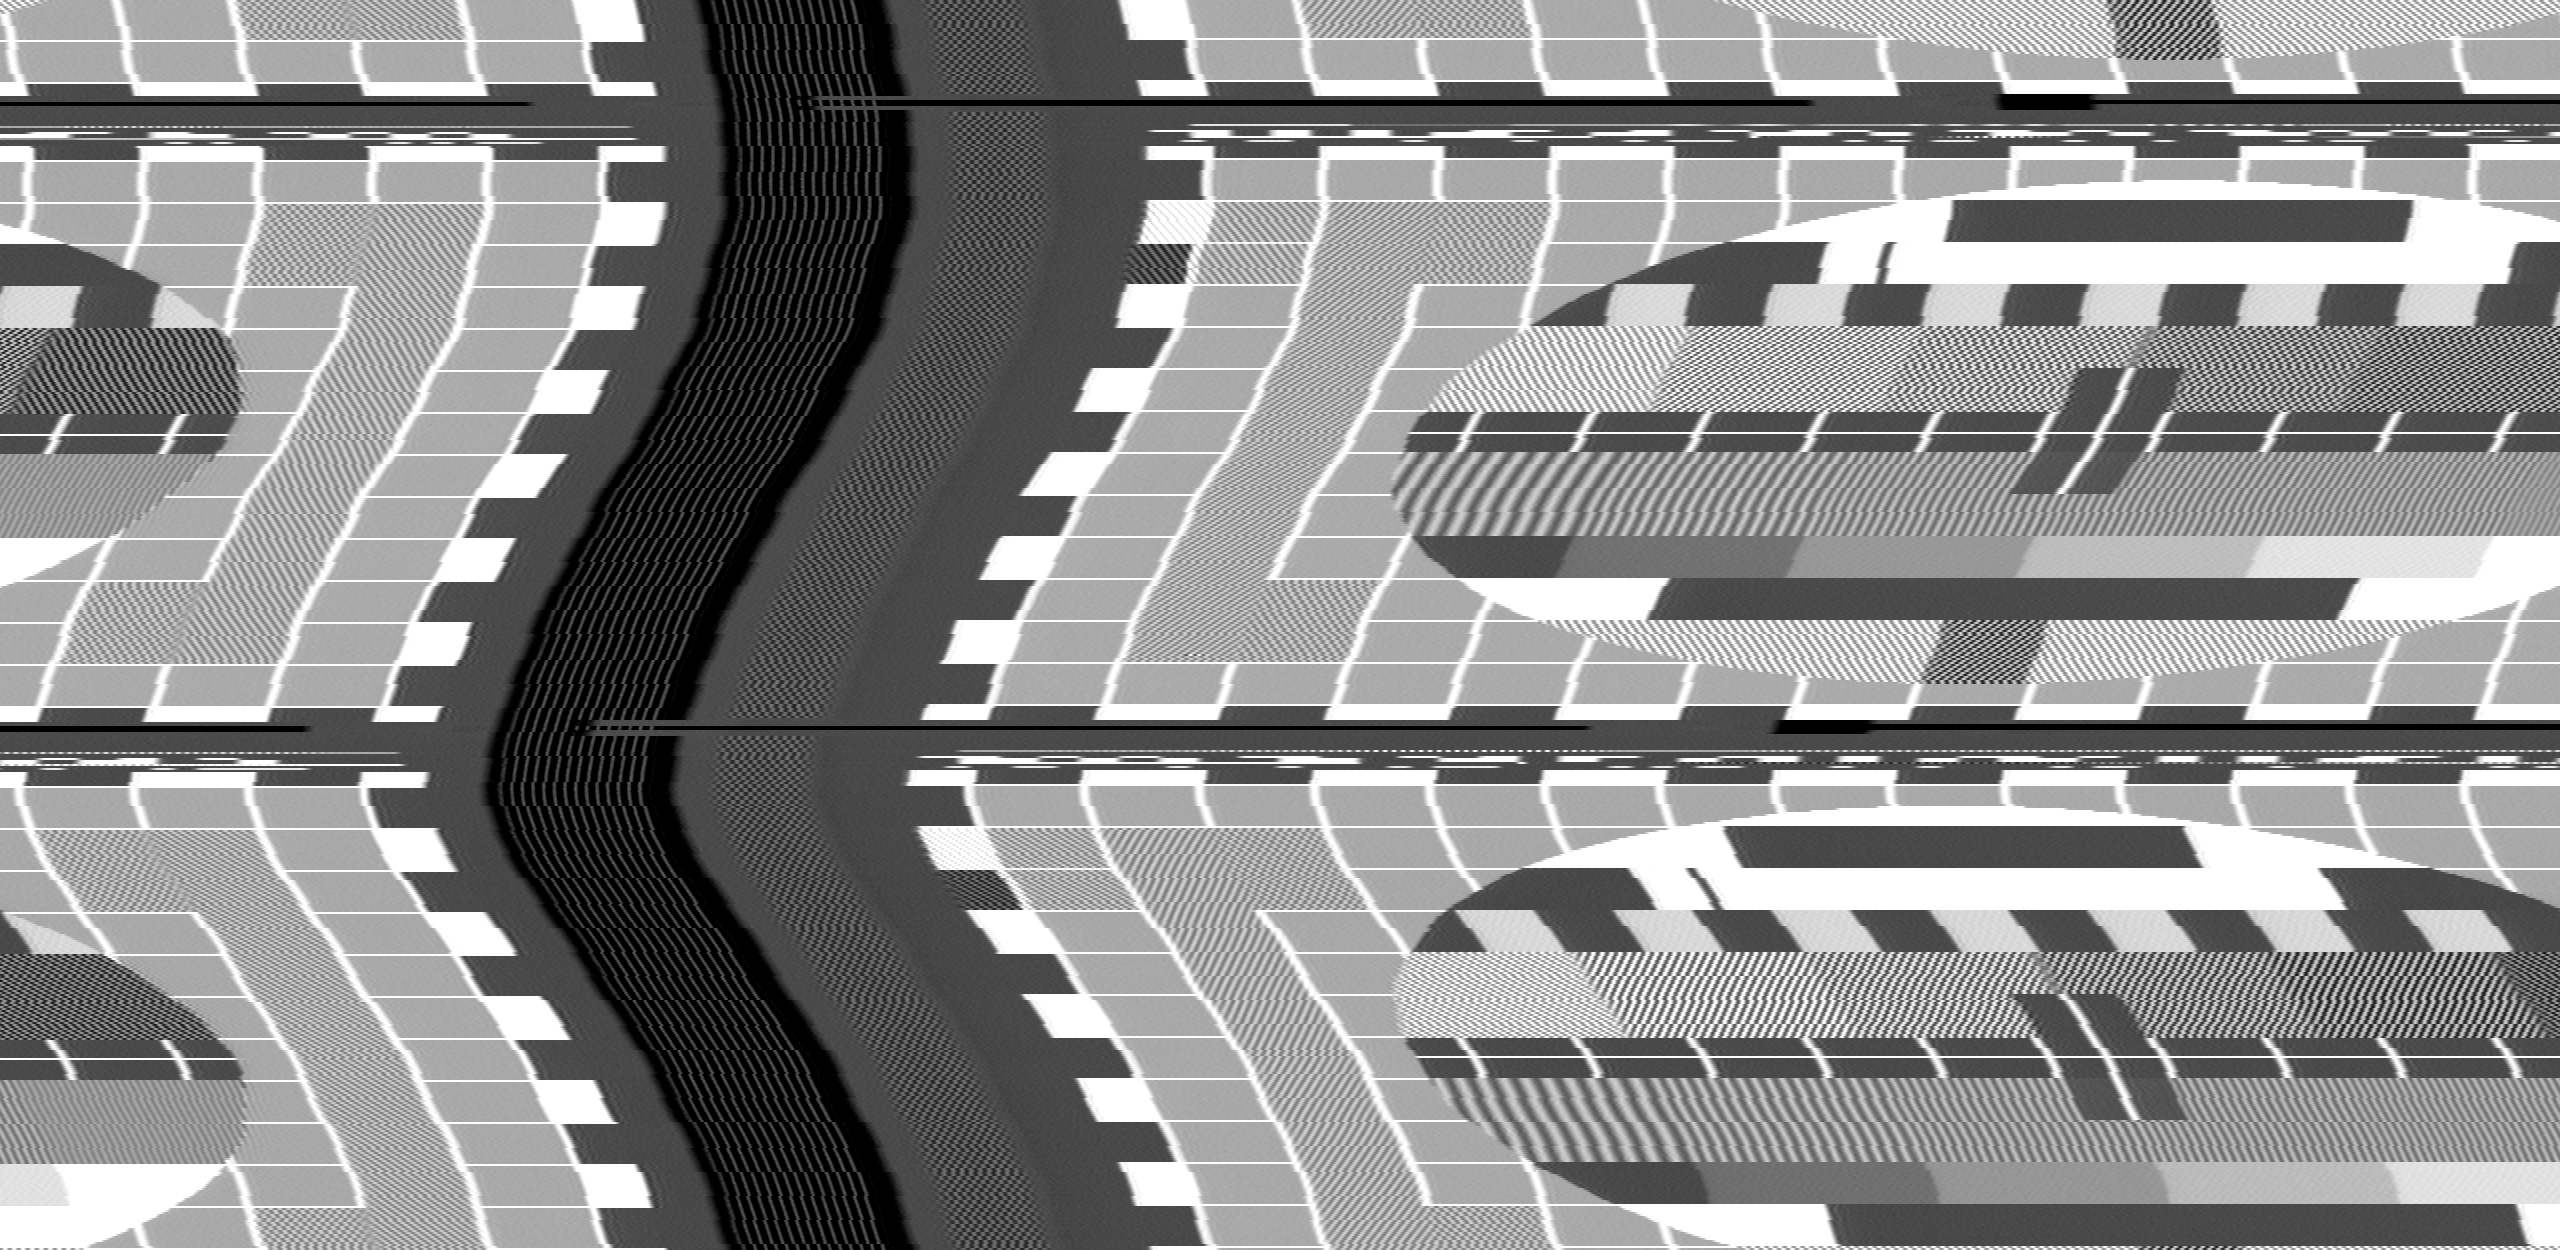

In [345]:
if True:
    reduced = (d[0]['demod'][:2560*1250] - iretohz(-40)) / hz_ire_scale
    lines16 = np.uint16(np.clip(reduced * (65535 / 140), 0, 65535) + 0.5)
drawdata(lines16, 2560, 625, hscale=1, vscale=2)

In [346]:
linelen = 2560

# run 12 peaks after first vsync to determine if this line's a keeper
def calc_vsync_linegaps(peaklist, baseline):
    for i in range(baseline, baseline - 7, -1):
        if peaklist[i][1] > .7 and peaklist[i + 1][1] < .6:
            tgap = peaklist[i + 1][0] - peaklist[i][0]

    for j in range(baseline + 3, baseline + 12, 1):
        if peaklist[j][1] > .7 and peaklist[j - 1][1] < .6:
            tgap += peaklist[j][0] - peaklist[j - 1][0]

    return i, tgap < (2560 * 1.5)

def haveframe(peaklist, vsyncs):
    if len(vsyncs) < 3:
        return False
    
    return (len(peaklist) - vsyncs[2]) > 16


def findsync_getpulses(frame, start):
    """returns: line #'s (zero delimited/padded, starts with 1) and gap to next frame """
    ds = frame['demod_sync']
    
    peaklist = []
    vsyncs = []
    
    linezero = None
    tgtire = -21.5
    
    # This is done as a while loop so each peak lookup is aligned to the previous one
    i = start
    while i < (len(ds) - linelen) and not haveframe(peaklist, vsyncs):
        #print(i)
        peakloc = np.argmax(ds[i:i + (linelen//2)]) #+ start
        peak = ds[i + peakloc]

        if peak > .3:
            # TODO: validity check for lack of rot goes here?

            if (len(peaklist) > 15) and (peaklist[-1][1] < .6) and (peak > .99):
                vsyncs.append(len(peaklist) - 1)
                
            # TODO: work out magic # for 48
            lineloc = i + peakloc - filterset['dgap_sync'] + 48
            zc = calczc(d[0]['demod'][lineloc:], 0, iretohz(tgtire), _count=16)
            if zc is not None:
                lineloc += zc            

            peaklist.append((lineloc, peak))

            # This allows all peaks to get caught properly
            i += peakloc + int(linelen * .4)
        else:
            i += linelen // 2

        if len(vsyncs) and (len(peaklist) - vsyncs[0]) == 12:
            linezero, is_beginning = calc_vsync_linegaps(peaklist, vsyncs[0])

            if not is_beginning: 
                return None, np.int(peaklist[linezero][0] + (linelen * 300))

    if not haveframe(peaklist, vsyncs):
        print(peaklist[vsyncs[0]][0] - (8 * linelen))

    # now build the line location list
    linelocs = [peaklist[linezero][0]]
    
    for i in range(linezero + 1, vsyncs[2] + 8):
        if inrange(peaklist[i][1], 0.7, 0.85): # full line
            linelocs.append(peaklist[i][0])
        elif inrange(peaklist[i][1], 0.4, 0.55):
            if inrange(peaklist[i][0] - linelocs[-1], linelen * .95, linelen * 1.05):
                # XXX: magic # offset
                linelocs.append(peaklist[i][0] + 45)
        elif (peaklist[i][1] > .95) and (peaklist[i-1][1] < .95): # add three lines 
            gap = linelocs[-1] - linelocs[-2]
            linelocs.append(linelocs[-1] + gap)
            linelocs.append(linelocs[-1] + gap)
            linelocs.append(linelocs[-1] + gap)
        else:
            # skip for now
            None
            
    # XXX: magic #
    linelocs = np.array(linelocs) # - filterset['dgap_sync'] + 48
            
    return linelocs, linelocs[-4]

pulses = (None, 0)
while pulses[0] is None:
    pulses = findsync_getpulses(d[0], pulses[1])

In [347]:
tgtire = -21.5
calczc(d[0]['demod'][np.int(pulses[0][34]-1):], 0, iretohz(tgtire), _count=16)

1.6125889810097054

(600960,)
uint8 (626, 960) (626, 960)


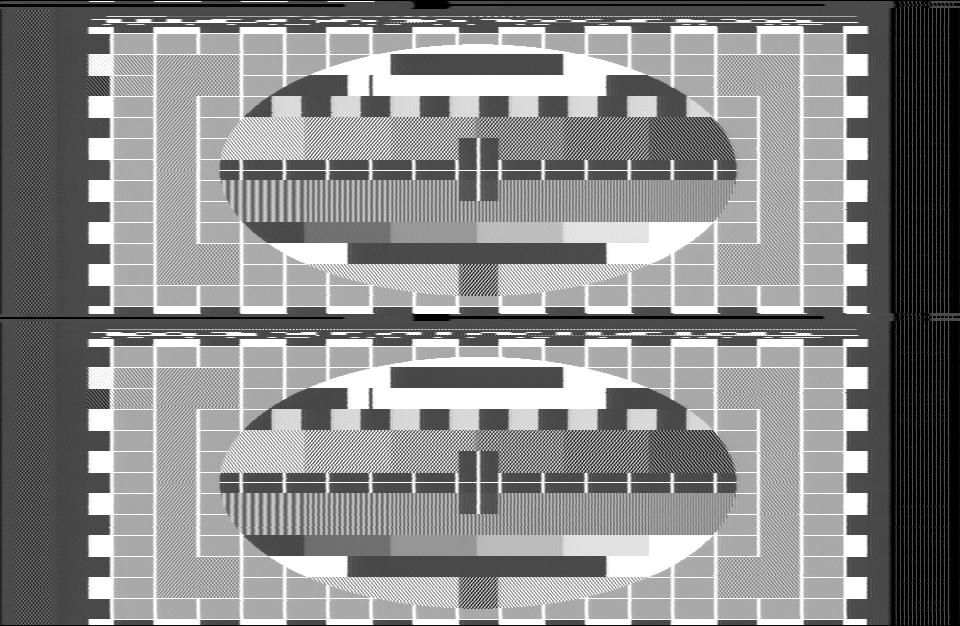

In [348]:
rv = downscale_field(d[0]['demod'], pulses[0], outwidth=params['linelen_pilot'])

reduced = (rv[0] - iretohz(-40)) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * (65535 / 140), 0, 65535) + 0.5)

drawdata(lines16, params['linelen_pilot'], 626, hscale=1, vscale=1)

In [349]:
downscale_demod = downscale_field(d[0]['demod'], pulses[0], outwidth=params['linelen_pilot'])
downscale_burst = downscale_field(d[0]['demod_burst'], pulses[0], outwidth=params['linelen_pilot'])
lineloc = pulses[0].copy()


In [350]:
ll = filterset['linelen_pilot']
lineloc = pulses[0].copy()

zc = [None] * 626

m = 0
c = 0

for l in range(1, 624):
    area = slice((ll*l)+880, ll*(l+1))

    ds_pilot = downscale_burst[0][filterset['Fburst_delay']:][area]
    argmax = np.argmax(ds_pilot)
    blevel = (ds_pilot[argmax] - ds_pilot[argmax+2] ) / hz_ire_scale
    zc[l] = calczc(ds_pilot, argmax, 0, _count=16, edge='falling') 
    print(l, np.argmax(ds_pilot), blevel, zc[l])
    
    if inrange(blevel, 15, 30) and (zc[l] < 30):
        print(l, 'hline')
    elif inrange(blevel, 30, 75):
        m += zc[l]
        c += 1
    
tgt = int(np.round(m / c))

1 20 29.45028074003999 20.605768017145287
1 hline
2 20 27.291977491973704 20.556915425737355
2 hline
3 48 60.28738319586291 49.17431148818566
4 49 54.797802585249975 49.66349271976349
5 49 57.12798814530307 50.29443675180599
6 20 34.14627031117915 21.001361409751162
7 20 32.36739687965084 20.70586544341817
8 44 62.36442012052153 45.004232558750395
9 44 60.54607502820524 45.079810783073256
10 44 61.04832115333607 45.150712944152254
11 44 60.30163015317436 45.05880924987717
12 44 60.64095542579999 44.92183272119829
13 44 61.60000993326333 45.039914013230906
14 44 57.65495958398744 45.273681220912124
15 44 60.12761432900742 44.980719961123896
16 44 60.64852822744065 45.05373809769088
17 44 60.76294916055251 45.061013029855175
18 44 61.43066539637999 45.09424887572689
19 44 61.814027591037934 44.95825939344318
20 44 62.20724399868994 45.0307867151122
21 44 61.63339234213487 45.08132208782628
22 44 61.839306559065285 44.995822494155995
23 44 61.769467159481785 44.942541984853484
24 44 59.13

354 44 60.34684641184035 44.89109944993697
355 44 60.477563242656004 44.99600907336954
356 44 58.47731473292036 44.780734618450474
357 44 59.87356879081958 45.11846942982777
358 44 61.460940981889244 45.013076184988705
359 44 58.46658694532575 44.74110753697381
360 44 59.22677387265586 45.04824889435754
361 44 60.67470780678705 45.079528958161305
362 44 59.45959351460342 45.19558637658027
363 44 59.51733018564223 45.02702855472507
364 44 58.075762522872715 45.25175350323406
365 44 60.394766703201164 44.88177206488827
366 44 56.588729074684 44.71051820295204
367 44 60.17640337094145 44.84546727077509
368 44 60.63677801530986 45.132355867310174
369 44 60.87265479385392 44.93209059740908
370 44 60.00130218000387 44.87660061754057
371 44 61.014837138234896 44.916867168123545
372 44 58.122562200389325 44.81834854373132
373 44 60.490965598930636 44.950512031926166
374 44 60.89108110944947 44.964152097229814
375 44 60.298763328543046 44.91770957223359
376 44 59.799190271685525 44.832618929286

In [351]:
for l in range(1, 624):
    if zc[l - 1] is not None and (np.abs(zc[l - 1] - tgt) < 2):
        lineloc[i] -= ((zc[l - 1] - tgt) * filterset['freq'] / filterset['pilot_mhz'] *.2)
    else:
        zc[l] = None
        
for l in range(1, 624):
    if zc[l] is None:
        lineloc[i] = ((lineloc[i + 1] - lineloc[i - 1]) / 2) + lineloc[i - 1]



(600960,)
uint8 (626, 960) (626, 960)


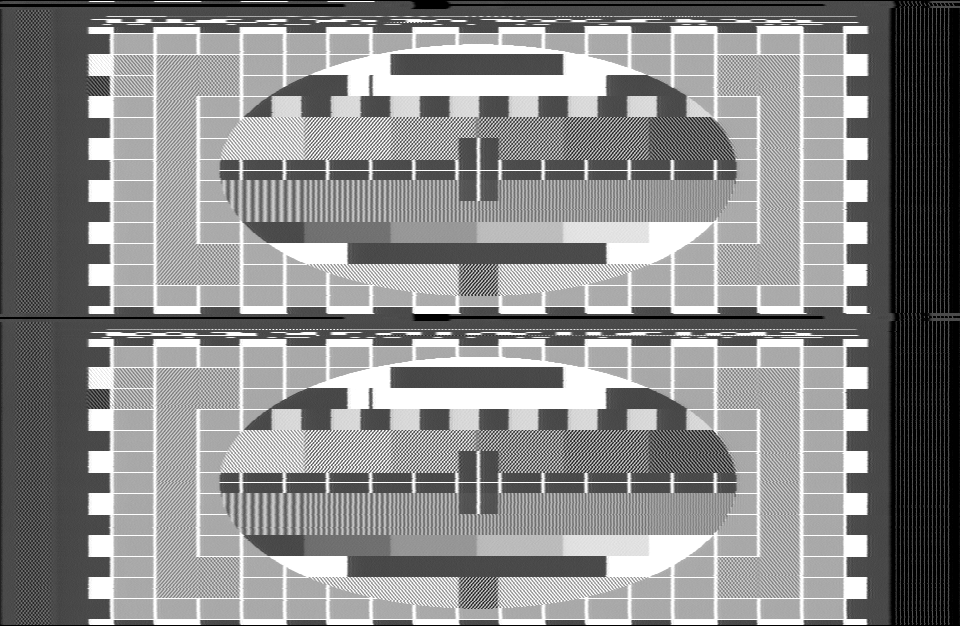

In [352]:
rv = downscale_field(d[0]['demod'], lineloc, outwidth=params['linelen_pilot'])

reduced = (rv[0] - iretohz(-40)) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * (65535 / 140), 0, 65535) + 0.5)

drawdata(lines16, params['linelen_pilot'], 626, hscale=1, vscale=1)

(710510,)
uint8 (626, 1135) (626, 1135)


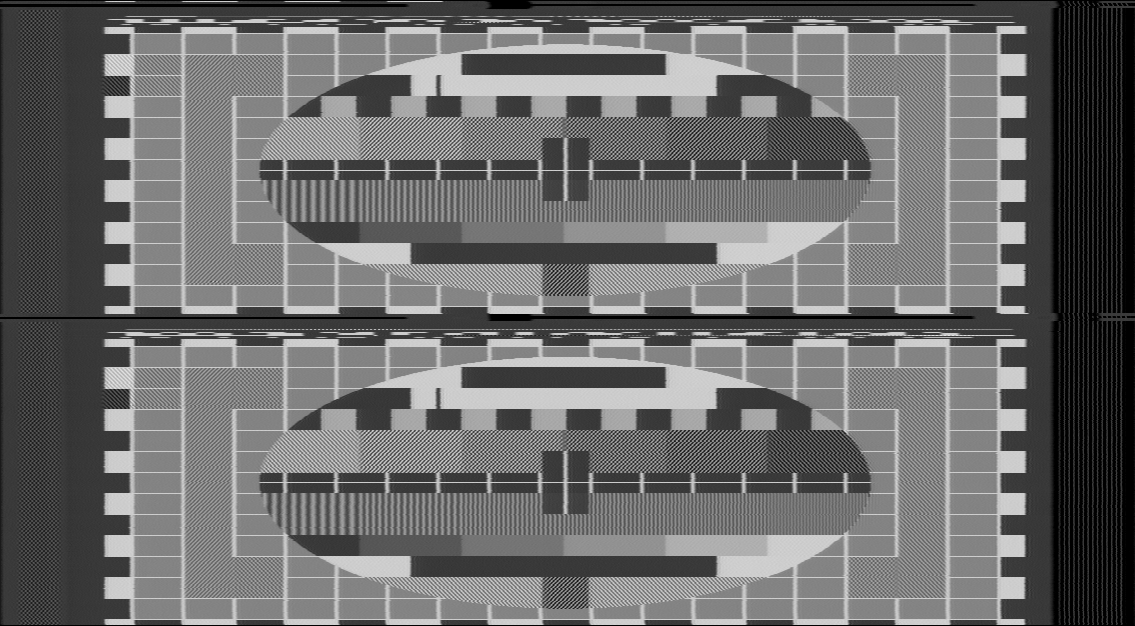

In [357]:
rv_4fsc = downscale_field(d[0]['demod'], lineloc, outwidth=params['linelen_4fsc'])

reduced = (rv_4fsc[0] - iretohz(-40)) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * (65535 / 180), 0, 65535) + 0.5)

drawdata(lines16, params['linelen_4fsc'], 626, hscale=1, vscale=1)

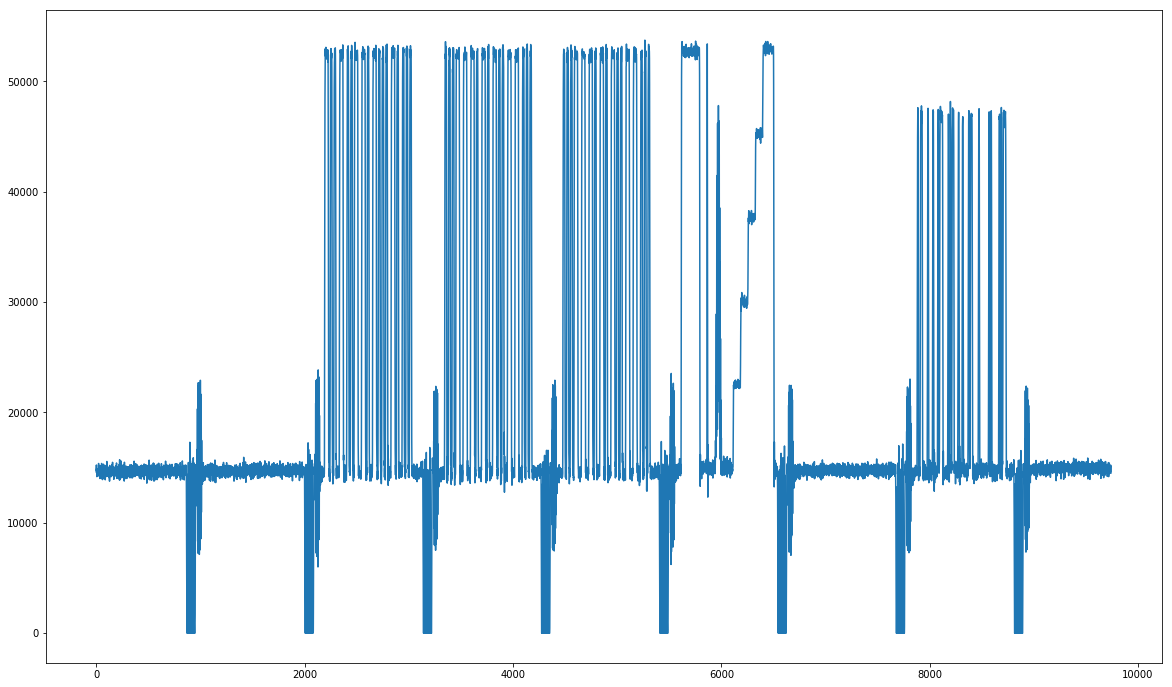

In [358]:
plt.plot(lines16[974*20:974*30])

(641720,)
uint8 (610, 1052) (610, 1052)


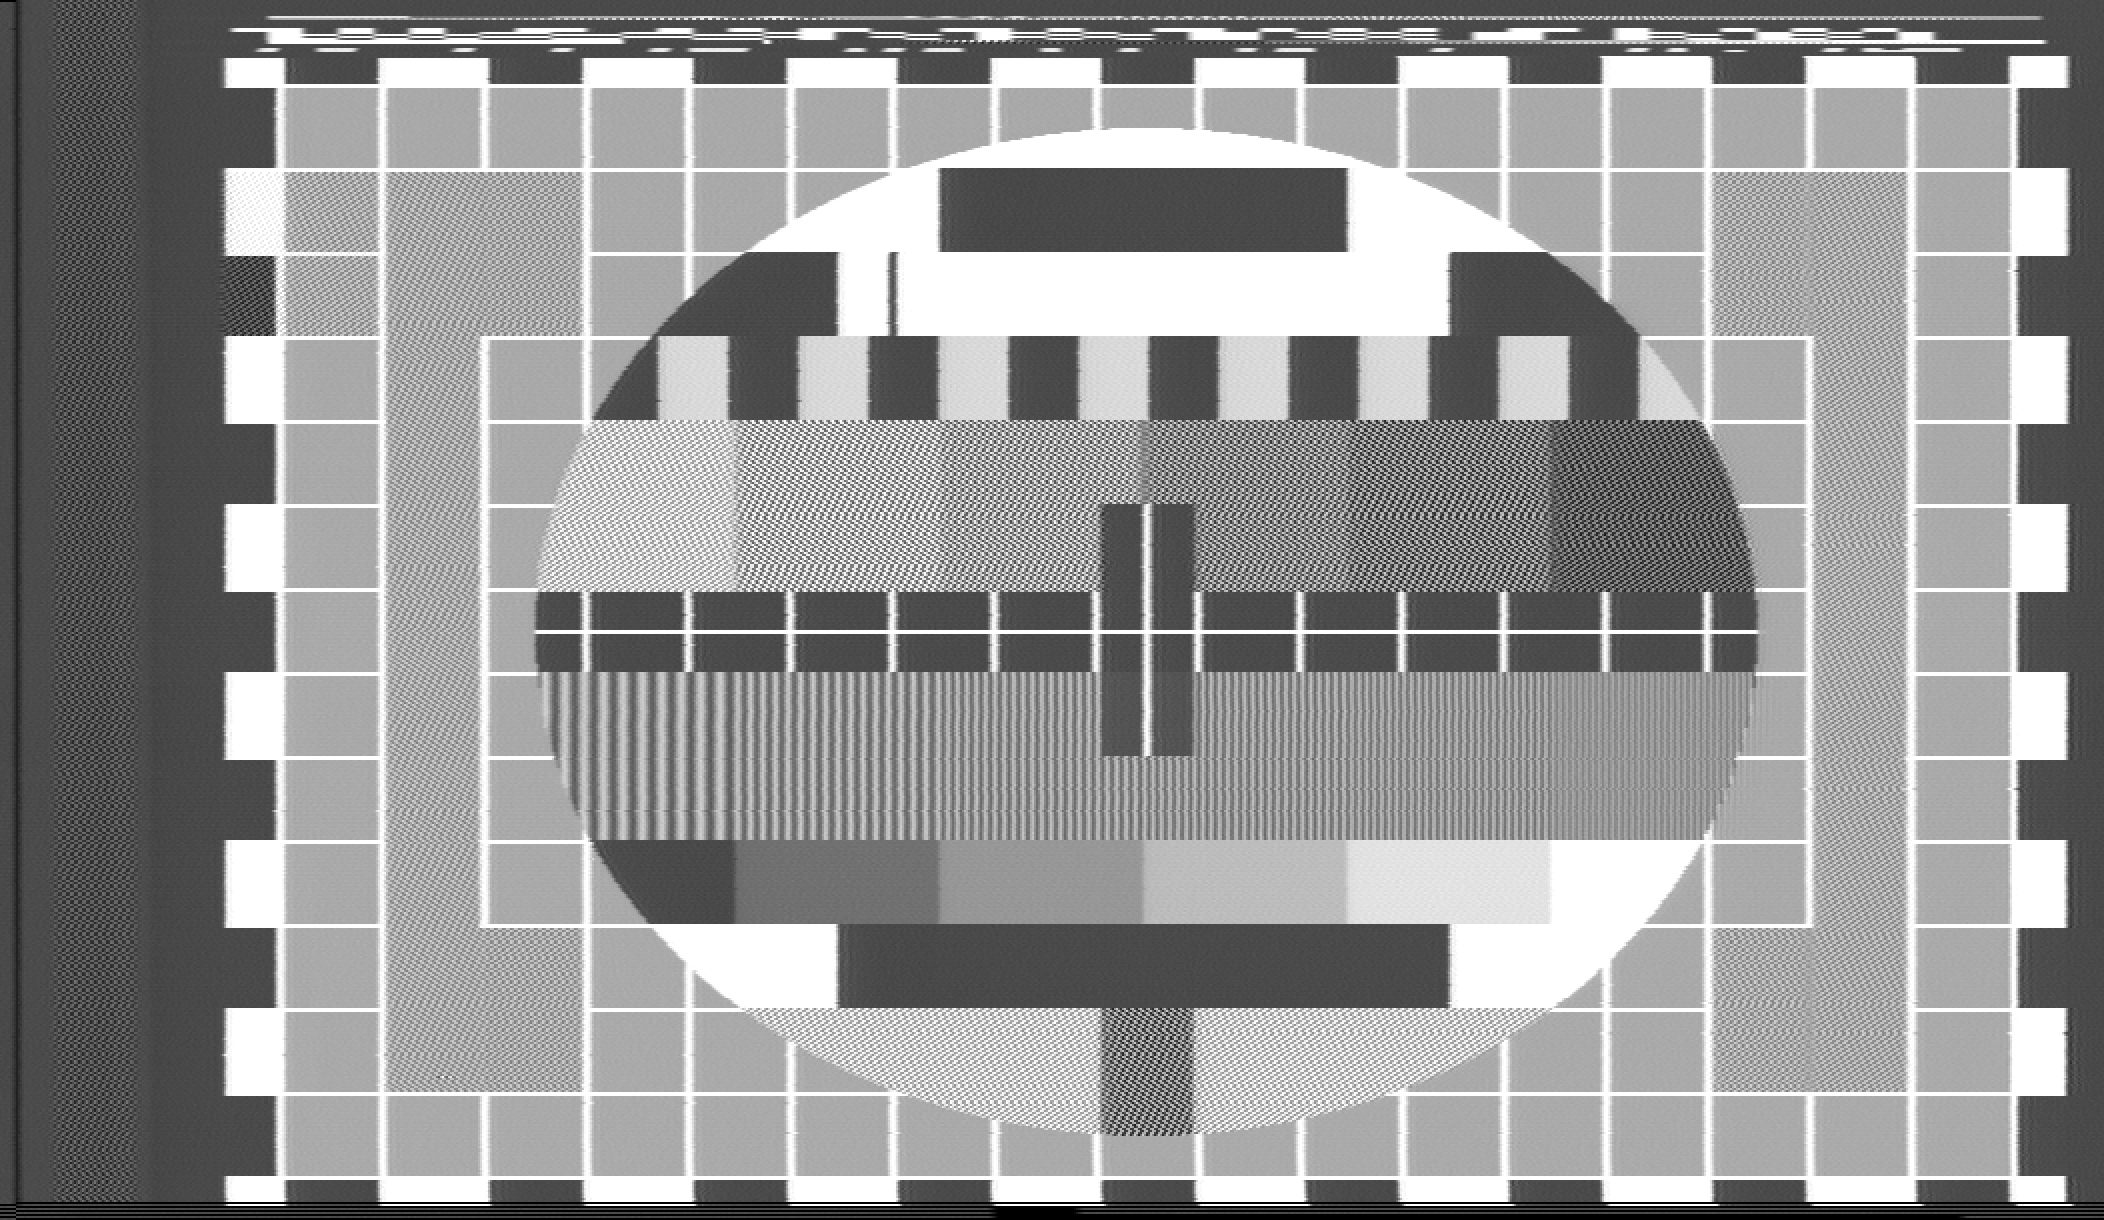

In [359]:
# this maps the frame line #'s into ld-decode tbc/comb filter line #'s.
def  buildlinemap_pal():
    linemap = {}
    
    for i in range(0, 610, 2):
        linemap[i] = ((i // 2) + 12)
        linemap[i + 1] = ((i // 2) + 325)
        
    return linemap

# This produces an ld-decode comb-ntsc.cxx compatible frame.  This is not optimal anymore, but it's what
# i've got!
def formatoutput_pal(scaledframe, burstlevel):
    outwidth = 1052

    linemap = buildlinemap_pal()
    
    combined = np.zeros((outwidth * 610), dtype=np.double)
    for i in range(0, 610):
        curline = linemap[i]
        #print(i, curline)
        combined[((i + 0) * outwidth):((i + 1) * outwidth)] = scaledframe[curline * params['linelen_4fsc']: (curline * params['linelen_4fsc']) + outwidth]
        
    reduced = (combined - iretohz(-40)) / hz_ire_scale
    lines16 = np.uint16(np.clip(reduced * (65535 / 140), 0, 65535) + 0.5)

    # crop the 16-bit frame down to 844x505 for ld-decode
    
    frameout = np.zeros((1052 * 610), dtype=np.uint16)
    offset = -8
    
    # copy the first line - not that it matters...
    frameout[-offset:outwidth] = lines16[0: outwidth + offset]
    
    for i in range(1, 610):
        # copy the line set
        frameout[(i + 0) * outwidth: (i + 1) * outwidth] = lines16[((i + 0) * outwidth) + offset: ((i + 0) * outwidth) + outwidth + offset]

    return combined, lines16, frameout

    for i in range(0, 610):
        curline = linemap[i]
    
        if not burstlevel[curline][0]:
            frameout[((i + 0) * 844)] = 16384
        else:
            frameout[((i + 0) * 844)] = 32768

        clevel = .58

        frameout[((i + 0) * 844) + 1] = np.uint16(327.67 * clevel * burstlevel[curline][1])



o = formatoutput_pal(rv_4fsc[0], None)

drawdata(o[2], 1052, 610, hscale=2, vscale=2)

In [360]:
len(o[2])
outfile = open('tmp.tbc', 'wb')
outfile.write(o[2])

1283440

In [287]:
#early code
if False:
    ll = filterset['linelen_pilot']
    lineloc = pulses[0].copy()

    offsets = [None] * 626

    for l in range(1, 624):
        area = slice((ll*l)+885, ll*(l+1))

        ds_pilot = downscale_burst[0][filterset['Fburst_delay']:][area]
        #ds_pilot = downscale_demod[0][area].copy()

        offsets[l + 1] = None

        #if not inrange(ds_pilot, iretohz(-43-53), iretohz(10)).all():
    #        print("ERR ", l)
    #        continue

        ds_pilot -= np.mean(ds_pilot)

        offset = 0
        i = pilot_begin
        c = 0
        while i < pilot_end:
            zc = calczc(ds_pilot, i, 0, _count=16, edge='falling')
            if zc is not None:
                offset += (np.round(zc/4)*4) - zc
                i += 4
                print(i, zc, np.round(zc/4)*4, offset)
                c += 1
            else:
                break

        if c > 2:
            #print(l, offsets1[l + 1], offsets[l + 1], offset / c)
            #lineloc[l + 1] += (offset / c) * filterset['freq'] / filterset['pilot_mhz']
            offsets[l + 1] = offset / c

        print(l, offsets1[l + 1], offsets[l + 1])


    lineloc = pulses[0].copy()
    for i in range(1, 625):
        print(i, offsets[i])
        if offsets[i] is not None:
            lineloc[i] -= (offsets[i] * filterset['freq'] / filterset['pilot_mhz'] *.2)

    for i in range(1, 625):
        if offsets[i] is None:
            lineloc[i] = ((lineloc[i + 1] - lineloc[i - 1]) / 2) + lineloc[i - 1]
            print(i, lineloc[i - 1], lineloc[i], lineloc[i + 1])

    downscale_demod = downscale_field(d[0]['demod'], lineloc, outwidth=params['linelen_pilot'])
    downscale_burst = downscale_field(d[0]['demod_burst'], lineloc, outwidth=params['linelen_pilot'])


40 35.84314375887755 36.0 0.15685624112244767
44 39.864474411793985 40.0 0.2923818293284626
48 43.88282876719724 44.0 0.40955306213122356
1 None 0.1365176873770745
40 36.19635958230343 36.0 -0.19635958230342965
44 40.20395020732543 40.0 -0.40030978962885655
48 44.20557707583185 44.0 -0.6058868654607039
2 None -0.20196228848690131
40 37.04928582604076 36.0 -1.0492858260407587
44 41.05604322699949 40.0 -2.1053290530402506
48 45.0616644123319 44.0 -3.166993465372151
3 1.163777818291777 -1.0556644884573838
40 37.963882811131526 36.0 -1.9638828111315263
44 41.962822786446644 40.0 -3.92670559757817
48 45.979498124175834 44.0 -5.906203721754004
4 0.19216932147786045 -1.9687345739180013
40 34.750876270072624 36.0 1.2491237299273763
44 38.806337459683384 40.0 2.4427862702439924
48 42.825617161343054 44.0 3.6171691089009386
5 -0.2218228428214175 1.2057230363003129
40 35.74389986643962 36.0 0.2561001335603805
44 39.73023207298777 40.0 0.5258680605726127
48 43.72476630267779 44.0 0.801101757894819

44 39.93034643120435 40.0 0.14904504927353202
48 43.9411818512096 44.0 0.20786319806393294
86 -0.010578286293139172 0.06928773268797765
40 36.129757563744036 36.0 -0.12975756374403602
44 40.130275269651875 40.0 -0.2600328333959112
48 44.13456455493872 44.0 -0.3945973883346312
87 -0.014095760470451543 -0.1315324627782104
40 36.13637753632101 36.0 -0.1363775363210067
44 40.138891856731014 40.0 -0.2752693930520209
48 44.14860432738616 44.0 -0.4238737204381806
88 -0.019081309387817196 -0.1412912401460602
40 36.114769305776974 36.0 -0.1147693057769743
44 40.12055356718245 40.0 -0.2353228729594221
48 44.132187948757604 44.0 -0.3675108217170262
89 0.158118804716608 -0.12250360723900873
40 35.96495526290984 36.0 0.03504473709016054
44 39.95252365965312 40.0 0.08252107743704329
48 43.95164804823679 44.0 0.13087302920025223
90 -0.027115510055724695 0.04362434306675075
40 35.93135968171717 36.0 0.06864031828283146
44 39.93624984316792 40.0 0.1323904751149101
48 43.94603562665424 44.0 0.1863548484

250 0.008361444208044114 -0.22931823916648617
40 36.301343042521204 36.0 -0.3013430425212036
44 40.30468061113581 40.0 -0.6060236536570116
48 44.312681461113954 44.0 -0.9187051147709653
251 -0.014429257029810572 -0.30623503825698845
40 36.257373298325625 36.0 -0.25737329832562494
44 40.25571675340082 40.0 -0.5130900517264436
48 44.2627564361925 44.0 -0.7758464879189404
252 -0.018270072948010824 -0.2586154959729801
40 36.20670383659332 36.0 -0.20670383659332003
44 40.222637424696956 40.0 -0.4293412612902756
48 44.23302917675901 44.0 -0.6623704380492867
253 -0.0020159064143333203 -0.2207901460164289
40 35.653746735085484 36.0 0.346253264914516
44 39.66326633260214 40.0 0.6829869323123745
48 43.67602653598293 44.0 1.006960396329447
254 -0.015570194584230515 0.33565346544314895
40 35.90549321786295 36.0 0.09450678213705288
44 39.90836487800028 40.0 0.18614190413677534
48 43.922615549037126 44.0 0.26352635509964983
255 0.0039235644173700734 0.08784211836654994
40 36.250156830604055 36.0 -0.

40 35.86806746131351 36.0 0.1319325386864918
44 39.87425113983899 40.0 0.2576813988475024
48 43.881687872045134 44.0 0.3759935268023682
411 -0.010616131043349242 0.1253311756007894
40 36.16241620192765 36.0 -0.16241620192764827
44 40.170877231504164 40.0 -0.3332934334318125
48 44.182846502327834 44.0 -0.5161399357596466
412 0.0030402512895075042 -0.17204664525321553
40 36.11024936556006 36.0 -0.11024936556005827
44 40.10857354870754 40.0 -0.21882291426759792
48 44.11444152044363 44.0 -0.333264434711225
413 -0.00949139167163319 -0.11108814490374168
40 35.82146918133562 36.0 0.17853081866437748
44 39.83317168789986 40.0 0.3453591307645141
48 43.83834790668388 44.0 0.5070112240806353
414 0.005576784175436463 0.16900374136021176
40 35.60492998672317 36.0 0.395070013276829
44 39.62162768515663 40.0 0.773442328120197
48 43.63310971516885 44.0 1.1403326129513474
415 0.013161824670137415 0.38011087098378243
40 35.82831460790858 36.0 0.17168539209141898
44 39.838526528550254 40.0 0.333158863541

44 39.9905536788621 40.0 0.01942516025391683
48 43.99475540135611 44.0 0.02466975889780798
553 -0.023818212589624466 0.008223252965935993
40 35.67972131024212 36.0 0.32027868975787754
44 39.68333279969646 40.0 0.6369458900614191
48 43.689073598493515 44.0 0.9478722915679043
554 -0.00031469009748263943 0.31595743052263475
40 35.98337020147903 36.0 0.016629798520966688
44 39.994983245451095 40.0 0.021646553069871288
48 44.005181036833406 44.0 0.016465516236465305
555 -0.00547899280283796 0.005488505412155102
40 36.040191652158896 36.0 -0.04019165215889586
44 40.029036574554986 40.0 -0.06922822671388218
48 44.04078470155443 44.0 -0.11001292826831133
556 0.0040617570194262 -0.03667097608943711
40 36.172862123305904 36.0 -0.17286212330590445
44 40.17737854462502 40.0 -0.350240667930926
48 44.18352691054065 44.0 -0.5337675784715756
557 -0.00592529331348383 -0.17792252615719187
40 36.27059873120902 36.0 -0.2705987312090201
44 40.27899414682697 40.0 -0.5495928780359876
48 44.2909712201772 44.0

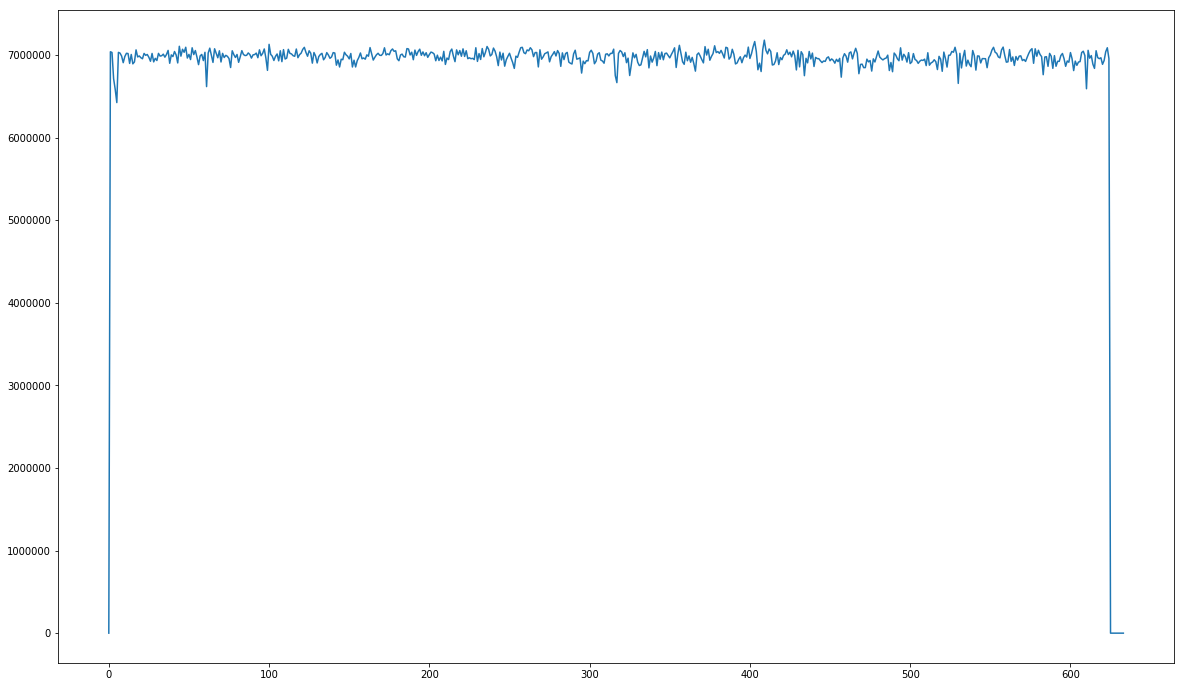

In [41]:
plt.plot((rv[0][932::params['linelen_pilot']]))

In [131]:
1052-78

974

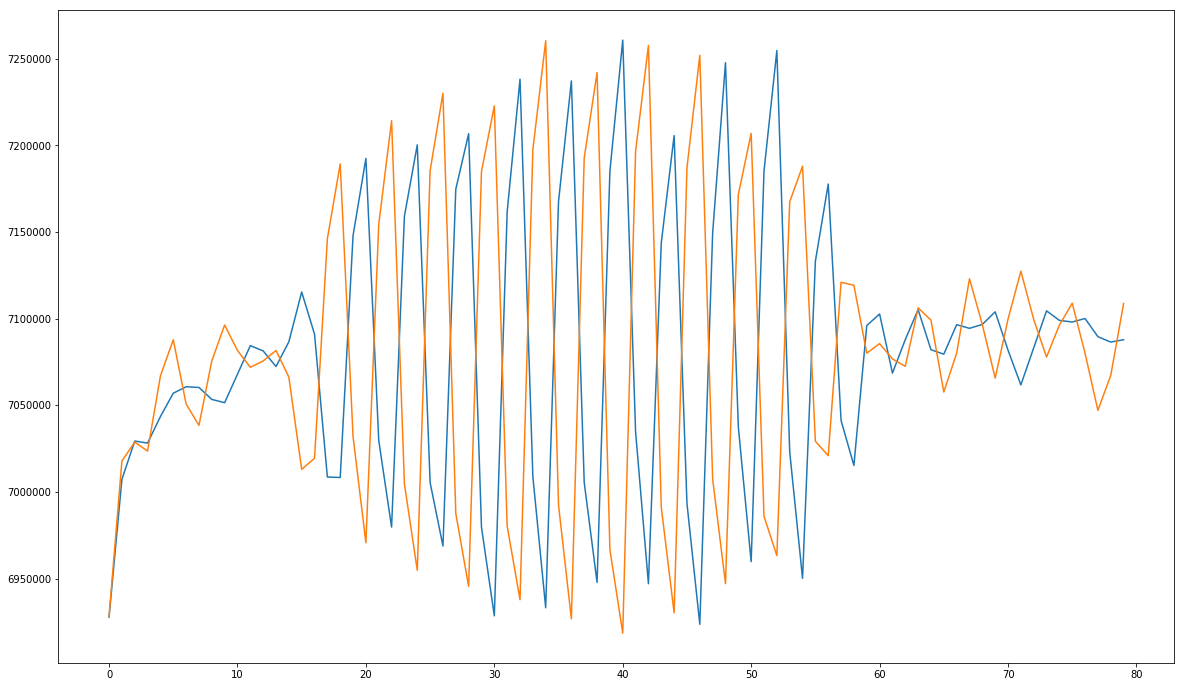

In [75]:
l = 48
plt.plot(rv_4fsc[0][(params['linelen_4fsc']*l)+0:params['linelen_4fsc']*(l+0)+80])
l = 47
#plt.plot(rv_4fsc[0][(params['linelen_4fsc']*l)+0:params['linelen_4fsc']*(l+1)])
plt.plot(rv_4fsc[0][(params['linelen_4fsc']*l)+0:params['linelen_4fsc']*(l+0)+80])

In [68]:
calczc(rv_4fsc[0][(params['linelen_4fsc']*l)+30:params['linelen_4fsc']*(l+0)+80], 0, iretohz(0), _count=60)

1.0363981539634881

In [ ]:
def calczc(data, _start_offset, target, edge='both', reverse=False, _count=10):
    start_offset = int(_start_offset)
    count = int(_count + 1)
    
    if edge == 'both': # capture rising or falling edge
        if data[start_offset] < target:
            edge = 'rising'
        else:
            edge = 'falling'

    if edge == 'rising':
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
               
    if len(locs) == 0:
        return None

    if reverse:
        index = -1
    else:
        index = 0
        
    x = start_offset + locs[index]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y

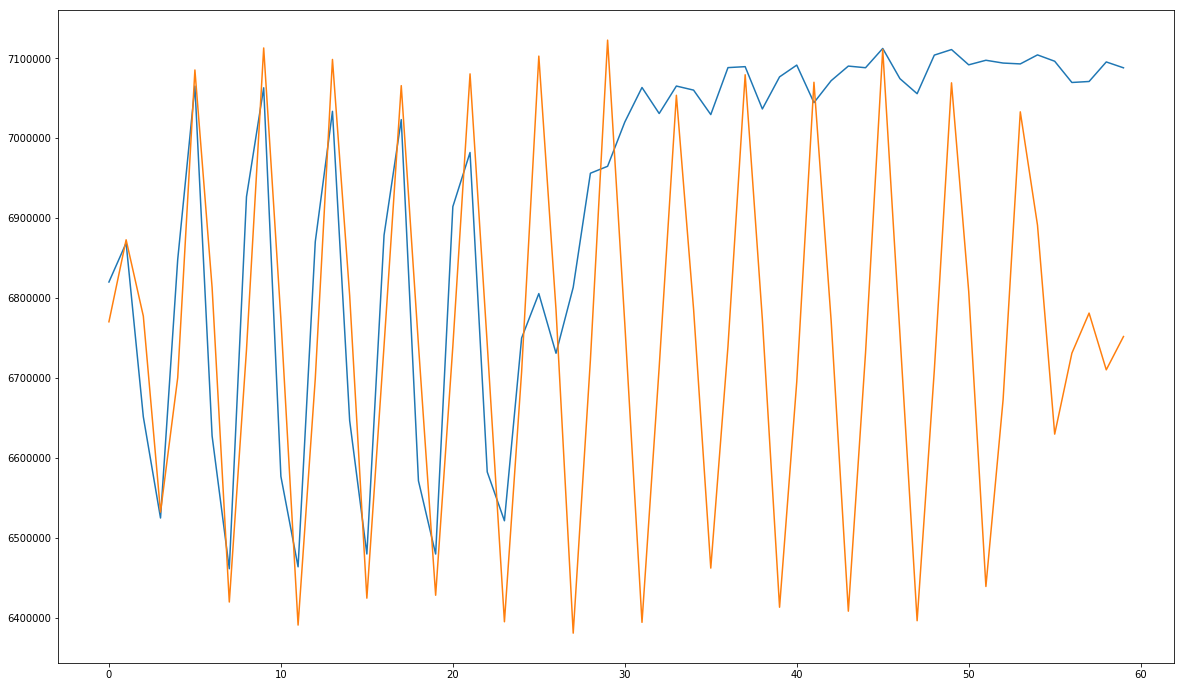

In [50]:
l = 2
plt.plot(rv[0][(params['linelen_pilot']*l)+900:params['linelen_pilot']*(l+1)])
l = 3
plt.plot(rv[0][(params['linelen_pilot']*l)+900:params['linelen_pilot']*(l+1)])

In [49]:
for l in range(0, 625):
    print(l, calczc(rv[0][params['linelen_pilot']*l:], 910, iretohz(-43), edge='falling', _count=20), calczc(rv[0][params['linelen_pilot']*l:], 910, iretohz(-43), edge='rising', _count=20))

/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars


0 inf None
1 909.249900065 911.24878833
2 909.631564295 911.718683686
3 910.046783831 910.052880438
4 910.353843713 910.995952928
5 910.592904675 907.139151007
6 909.587388115 911.502681892
7 909.57484584 911.547960837
8 909.543752608 911.607475994
9 909.657701874 911.68372151
10 909.560981319 911.595354123
11 909.476613634 911.41125422
12 909.429227206 911.437108765
13 909.6503518 911.694484249
14 909.464765161 911.516708957
15 909.684705325 911.741848567
16 909.597021934 911.689305859
17 909.192085475 911.286889769
18 909.442308406 911.47202786
19 909.522473288 911.584004887
20 909.515617778 911.553249131
21 909.57091587 911.674883808
22 909.381625965 911.406265854
23 909.406194677 911.512456988
24 909.375270657 911.420248871
25 909.417736659 911.445552543
26 909.542730748 911.56344363
27 909.359627929 911.47457844
28 909.587724969 911.603669174
29 909.481250354 911.527432747
30 909.53911019 911.573389988
31 909.441080893 911.453148316
32 909.479368732 911.547266921
33 909.389387854 

510 909.724530978 911.763936029
511 909.395608223 911.37481694
512 909.615305119 911.629430261
513 909.694271504 911.735933354
514 909.582856893 911.611240976
515 909.443441801 911.50841374
516 909.622219661 911.655381423
517 909.716575711 911.793331457
518 909.427254512 911.447417289
519 909.54336982 911.55435001
520 909.909263166 911.878709346
521 909.450125465 911.352930023
522 909.513955617 911.519650003
523 909.733198202 911.734385097
524 909.497770735 911.572893762
525 909.464664179 911.428467515
526 909.436378908 911.459278261
527 909.493964789 911.542293768
528 909.235186306 911.265811443
529 909.495755114 911.452417431
530 910.174769716 910.279134591
531 909.375832129 911.381287459
532 909.735337109 911.833903483
533 909.466044509 911.495702357
534 909.405289078 911.368087418
535 909.728500489 911.752890248
536 909.494214929 911.552537747
537 909.709135335 911.611915636
538 909.682041134 911.835370699
539 909.239407944 911.323048281
540 909.488487642 911.527036232
541 909.8249

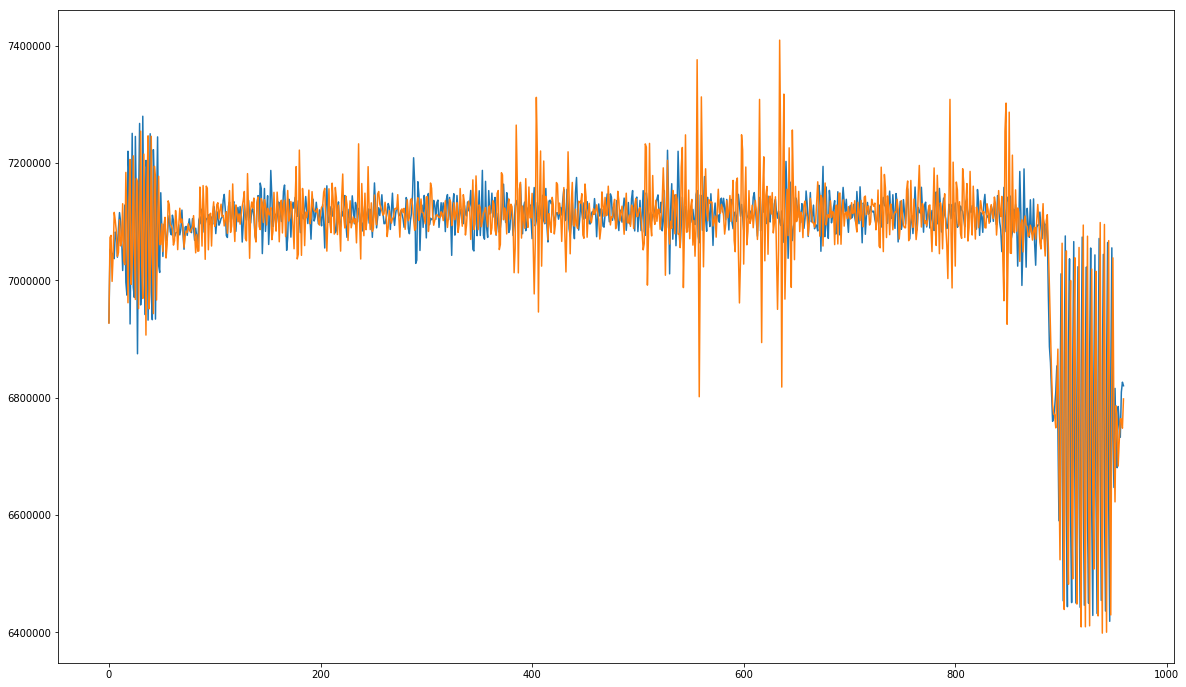

In [790]:
l = 341
plt.plot(rv[0][(params['linelen_pilot']*l)+0:params['linelen_pilot']*(l+1)])

l = 342
plt.plot(rv[0][(params['linelen_pilot']*l)+0:params['linelen_pilot']*(l+1)])


In [752]:
iretohz(-43)

6756000.0

In [740]:
tgtire=-21.5
tmp = []
for l in range(0, 625):
    c1 = calczc(rv[0][params['4fsc_len']*l:], 0, iretohz(tgtire), _count=50)
    c2 = calczc(rv[0][params['4fsc_len']*l:], 1130, iretohz(tgtire), _count=25)
    try:
#        tmp.append((c2-c1)*(64/1135))
        tmp.append(c1)
    except:
        tmp.append(None)
    

tmp

[None,
 3.4493645829401429,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 3.5366023975916629,
 3.7726390406250578,
 3.6191199014124753,
 3.7128678352397828,
 3.7781214388433648,
 3.6221469574351568,
 3.8358589166478438,
 3.5633325227551023,
 3.3876324614953166,
 3.9682674933415898,
 3.8362973116062502,
 3.4784530745663149,
 3.577634104759154,
 3.2068406592457124,
 3.6780142553894204,
 3.7336166089861029,
 3.5787367598365769,
 3.7661112143570117,
 3.4028007277102894,
 3.8086441390581576,
 3.3249161974326196,
 3.764420397367966,
 3.5114380738021542,
 3.3548149824905624,
 3.639968608082996,
 3.908348076570058,
 3.7289932055043198,
 3.7242020515410657,
 3.6669772802478198,
 4.1897382891561961,
 3.5860962323319105,
 3.6266316600535307,
 3.5819618211378779,
 3.6455747458476884,
 3.4713793385672651,
 3.2687277938409229,
 3.840422906468449,
 3.5060424505366923,
 3.7608368979385025,
 3.6722451087499017,
 3.9619831413011593,
 3.4761887152047106,
 3.6519665361620341,
 3.4306955165016633,
 4.1

In [737]:
tgtire=-21.5
tmp = []
for l in range(10, 400):
    c1 = calczc(rv[0][params['4fsc_len']*l:], 1040, iretohz(tgtire), _count=50)
    c2 = calczc(rv[0][params['4fsc_len']*l:], 1130, iretohz(tgtire), _count=25)
    try:
        tmp.append((c2-c1)*(64/1135))
    except:
        tmp.append(None)
    

tmp

[4.7021204509037462,
 4.6981337000279852,
 4.7046191698697832,
 4.6817037139698581,
 4.6839662329848304,
 4.6614589730265097,
 4.6853519548725862,
 4.7103837063901448,
 4.7087592250713799,
 4.67223968240285,
 4.6652010018907673,
 4.6143501071893258,
 4.6980299933741074,
 4.7097611209823311,
 4.6763073082888678,
 4.6880024356300085,
 4.6940519040833033,
 4.7049623779887009,
 4.6640669513271202,
 4.7103947399532462,
 4.714763591732237,
 4.7041400688199202,
 4.6911884178119143,
 4.6877742985185771,
 4.6855240972037864,
 4.7009923293083471,
 4.6923701325858662,
 4.7088946018423909,
 4.6792610814772848,
 4.6888360641406193,
 4.6758853470896362,
 4.6803740815773516,
 4.6926059516830403,
 4.6730749491121522,
 4.7075209736632235,
 4.682105305025817,
 4.7313752341933322,
 4.6765711034425292,
 4.737807663361207,
 4.6751956654228053,
 4.7007243857122951,
 4.6781631054308237,
 4.7217349225376086,
 4.6852888436735292,
 4.7056737421592292,
 4.6785263369668,
 4.6823096349757192,
 4.6944093232822608,


In [704]:
c2, c1

(None, 1056.2088664423175)

In [693]:
(1138.34-1056.08)*(64/1135)

4.638449339207048

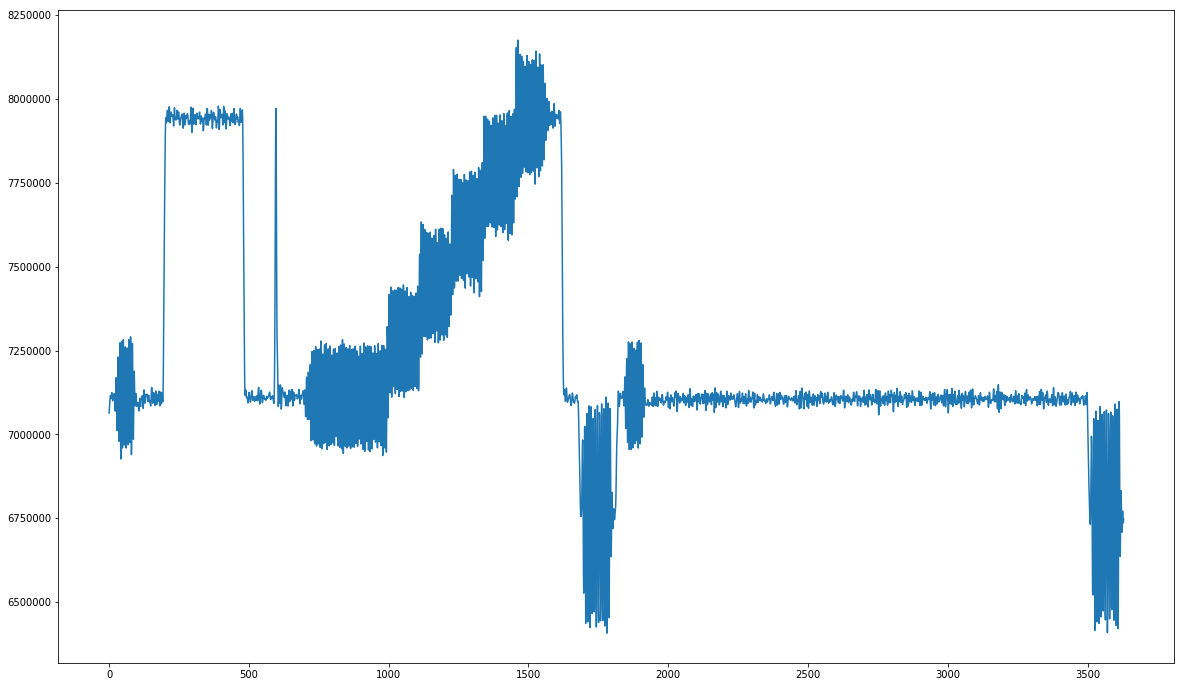

In [638]:
plt.plot(rv[0][(1820*23)+10:(1820*25)])

In [630]:
calcsnr(rv[0][(1820*24)+200:(1820*24)+420])

32.562495934216393

In [252]:
pulses[0][2]

781654

In [27]:
# Wow/flutter on Laserdisc cannot be computed merely by line length, but
# thankfully there's enough hsync data to compute it.

def calcwow(frame, linelist, rlinelen = 2540):
    llavg = {}
    llprev = rlinelen
    for i in range(1, 528):
        ll = linelist2[i + 1] - linelist2[i]

        if i > 2 and np.abs(ll - llprev) > 3:
            llavg[i] = llavg[i - 1]
        else:
            llavg[i] = rlinelen / ll
            
        llprev = ll

    return llavg

def downscale_field(data, lineinfo, wow, outwidth=1820):
    ilinepx = int(filterset['line_px'])
    dsout = np.zeros((len(lineinfo) * outwidth), dtype=np.double)    

    sfactor = [None]

    for l in range(1, 525):
        scaled = scale(data, lineinfo[l], lineinfo[l + 1], outwidth)
        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / outwidth)

        dsout[l * outwidth:(l + 1)*outwidth] = scaled / wow[l]
        
    return dsout, sfactor

def buildframe(frame, lineliist):
    badburst = np.zeros(526)
    linelist2, lineinfo_cphaseadj, offsets = cburstalign(frame, linelist, badburst)    
    
    wow = calcwow(frame, linelist)
    
    # XXX: should be able to compute this earlier.  need to know which burst we're looking at though!
    burstlevel = [None]
    field_cburst, sfactor = downscale_field(frame['demod_burst'][filterset['Fburst_delay']:], linelist2, wow, outwidth)
    for i in range(1, 525):
        fcb29 = field_cburst[int((i * outwidth) + ((outfsc * 7.25) + 1))]
        fcb_mean = np.mean(field_cburst[int((i * outwidth) + (outfsc * 2.5)):int((i * outwidth) + (outfsc * 12.5))])
        burstlevel.append((fcb29 > 0, (np.fabs(fcb29 - fcb_mean) * .85) / hz_ire_scale))

    scaledframe, sfactor = downscale_field(frame['demod'], lineinfo_cphaseadj, wow, outwidth)        
        
    return scaledframe, linelist2, burstlevel

# this maps the frame line #'s into ld-decode tbc/comb filter line #'s.
def  buildlinemap_ntsc():
    linemap = {}
    
    for i in range(0, 505, 2):
        linemap[i] = ((i // 2) + 10)
        linemap[i + 1] = ((i // 2) + 273)
        
    return linemap

# This produces an ld-decode comb-ntsc.cxx compatible frame.  This is not optimal anymore, but it's what
# i've got!
def formatoutput(scaledframe, burstlevel):
    outwidth = 910

    linemap = buildlinemap_ntsc()
    
    combined = np.zeros((outwidth * 506), dtype=np.double)
    for i in range(0, 505):
        curline = linemap[i]
        combined[((i + 0) * outwidth):((i + 1) * outwidth)] = scaledframe[curline * outwidth: (curline + 1) * outwidth]
        
    reduced = (combined - minn) / hz_ire_scale
    lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

    # crop the 16-bit frame down to 844x505 for ld-decode
    
    frameout = np.zeros((844 * 505), dtype=np.uint16)
    offset = -8
    
    # copy the first line - not that it matters...
    frameout[-offset:844] = lines16[0: 844 + offset]
    
    for i in range(1, 505):
        # copy the line set
        frameout[(i + 0) * 844: (i + 1) * 844] = lines16[((i + 0) * 910) + offset: ((i + 0) * 910) + 844 + offset]

    for i in range(0, 505):
        curline = linemap[i]
    
        if not burstlevel[curline][0]:
            frameout[((i + 0) * 844)] = 16384
        else:
            frameout[((i + 0) * 844)] = 32768

        clevel = .58

        frameout[((i + 0) * 844) + 1] = np.uint16(327.67 * clevel * burstlevel[curline][1])

    return combined, lines16, frameout

In [28]:
def runfilter_audio_phase2(filterset, frame_audio, start):
    left = frame_audio['audio_left'][start:start+blocklen].copy() 
    left_fft = np.fft.fft(left)
    audio_out_fft = audio_fdslice2(filterset, left_fft) * filterset['audio_lpf2'] #* adeemp
    left_out = np.fft.ifft(audio_out_fft).real / filterset['audio_fdiv2']
    
    right = frame_audio['audio_right'][start:start+blocklen].copy() 
    right_fft = np.fft.fft(right)
    audio_out_fft = audio_fdslice2(filterset, right_fft) * filterset['audio_lpf2'] #* adeemp
    right_out = np.fft.ifft(audio_out_fft).real / filterset['audio_fdiv2']
    
    return np.rec.array([left_out, right_out], names=['audio_left', 'audio_right'])

def audio_phase2(filterset, frame_audio):
    output_audio2 = np.zeros(len(frame_audio['audio_left']) // (filterset['audio_fdiv2'] // 1), dtype=frame_audio.dtype)

    # copy the first block in it's entirety, to keep audio and video samples aligned
    tmp = runfilter_audio_phase2(filterset, frame_audio, 0)
    output_audio2[:tmp.shape[0]] = tmp

    end = frame_audio.shape[0] #// filterset['audio_fdiv2']
    print(end)
    
    askip = 64
    sjump = blocklen - (askip * filterset['audio_fdiv2'])

    print(end, sjump)
    
    ostart = tmp.shape[0]
    for sample in range(sjump, frame_audio.shape[0] - sjump, sjump):
        print(sample, ostart, frame_audio.shape[0])
        tmp = runfilter_audio_phase2(filterset, frame_audio, sample)
        oend = ostart + tmp.shape[0] - askip
        output_audio2[ostart:oend] = tmp[askip:]
        ostart += tmp.shape[0] - askip

    print(sample, frame_audio.shape[0])
    tmp = runfilter_audio_phase2(filterset, frame_audio, end - blocklen - 1)
    output_audio2[output_audio2.shape[0] - (tmp.shape[0] - askip):] = tmp[askip:]

    return output_audio2


# right now defualt is 16/96, so not optimal :)
def downscale_audio(audio, lineinfo, filterset, timeoffset, wow, freq = 48000, scale=128):
    frametime = (filterset['line_period'] * 525) / 1000000 
    soundgap = 1 / freq

    # include one extra 'tick' to interpolate the last one and use as a return value
    # for the next frame
    arange = np.arange(timeoffset, frametime + soundgap, soundgap)
    locs = np.zeros(len(arange), dtype=np.float)
    swow = np.zeros(len(arange), dtype=np.float)

    for i, t in enumerate(arange):
        lineloc = ((t * 1000000) / filterset['line_period']) + 1

        sampleloc = lineinfo[np.int(lineloc)]
        sampleloc += (lineinfo[np.int(lineloc) + 1] - lineinfo[np.int(lineloc)]) * (lineloc - np.floor(lineloc))

        wowratio = 1 - (lineloc - np.floor(lineloc))
        swow[i] = wow[np.int(lineloc)] * (1 - wowratio)
        swow[i] += wow[np.int(lineloc + 1 )] * (wowratio)
        
        locs[i] = sampleloc / scale

    print(locs[0], locs[-1], lineloc)
        
    # for now output 16/192 audio - need better scaling!

    output = np.zeros((2 * (len(arange) - 1)), dtype=np.int16)

    # use two passes so the next location can be known
    for i in range(len(arange) - 1):    
        # rough linear approx for now
        ratio = 1 - (locs[i] - np.floor(locs[i]))
        output_left = (audio['audio_left'][np.int(locs[i])] * ratio) 
        output_left += (audio['audio_left'][np.int(locs[i + 1])] * (1 - ratio))

        output_right = (audio['audio_right'][np.int(locs[i])] * ratio) 
        output_right += (audio['audio_right'][np.int(locs[i + 1])] * (1 - ratio))

        #print(swow[i])
        
        output_left /= swow[i]
        output_right /= swow[i]
        
        output_left -= filterset['audio_lfreq']
        output_right -= filterset['audio_rfreq']
        
        output[(i * 2) + 0] = int(np.round(output_left * 32767 / 150000))
        output[(i * 2) + 1] = int(np.round(output_right * 32767 / 150000))
#        output[(i * 2) + 0] = output_left
#        output[(i * 2) + 1] = output_left
            
    return output, arange[-1] - frametime


In [30]:
outfsc = 4
outwidth = int(outfsc * 227.5)

ilinepx = filterset['line_px']

needmtf = 0.2
rdata = None

lines = int(filterset['frame_lines'] * 1.25)
ilinepx = int(filterset['line_px'])
readlen = lines * ilinepx

firstloc = 0
curloc = firstloc

outfile = open('tmp.tbc', 'wb')
outfile_audio = open('tmp.pcm', 'wb')

frameno = 0
linelist = None

nexttimeoffset = 0

record = []

while linelist is None or frameno < 1:
    print(curloc)
    frame, frame_audio = demod(infile, curloc, curloc + readlen, filterset, mtf_level=needmtf)
    linelist, nextread = findsync_getpulses(frame, 512)

    curloc += nextread
    
    if linelist is None:
        continue
    
    scaledframe, linelist2, burstlevel = buildframe(frame, linelist)
    combined, output_fullframe, output_cropped = formatoutput(scaledframe, burstlevel)
    
    frameno += 1
    
    outfile.write(output_cropped)

    processphillipscode(frame['demod'], linelist2)
    
    if filterset['analog_audio'] == True:
        wow = calcwow(frame, linelist2)
        
        final_audio = audio_phase2(filterset, frame_audio)
        output_audio, nexttimeoffset = downscale_audio(final_audio, linelist2, filterset, nexttimeoffset, wow)

        #nexttimeoffset = 0
        
        outfile_audio.write(output_audio)
        
    record.append((frame_audio, linelist2))
    #record.append((frame, frame_audio, linelist2, final_audio))

0
635512
1271024
1906536
2542048
3177560
3813072
5116604
5752116


KeyboardInterrupt: 

(425376,)
uint8 (504, 844) (504, 844)


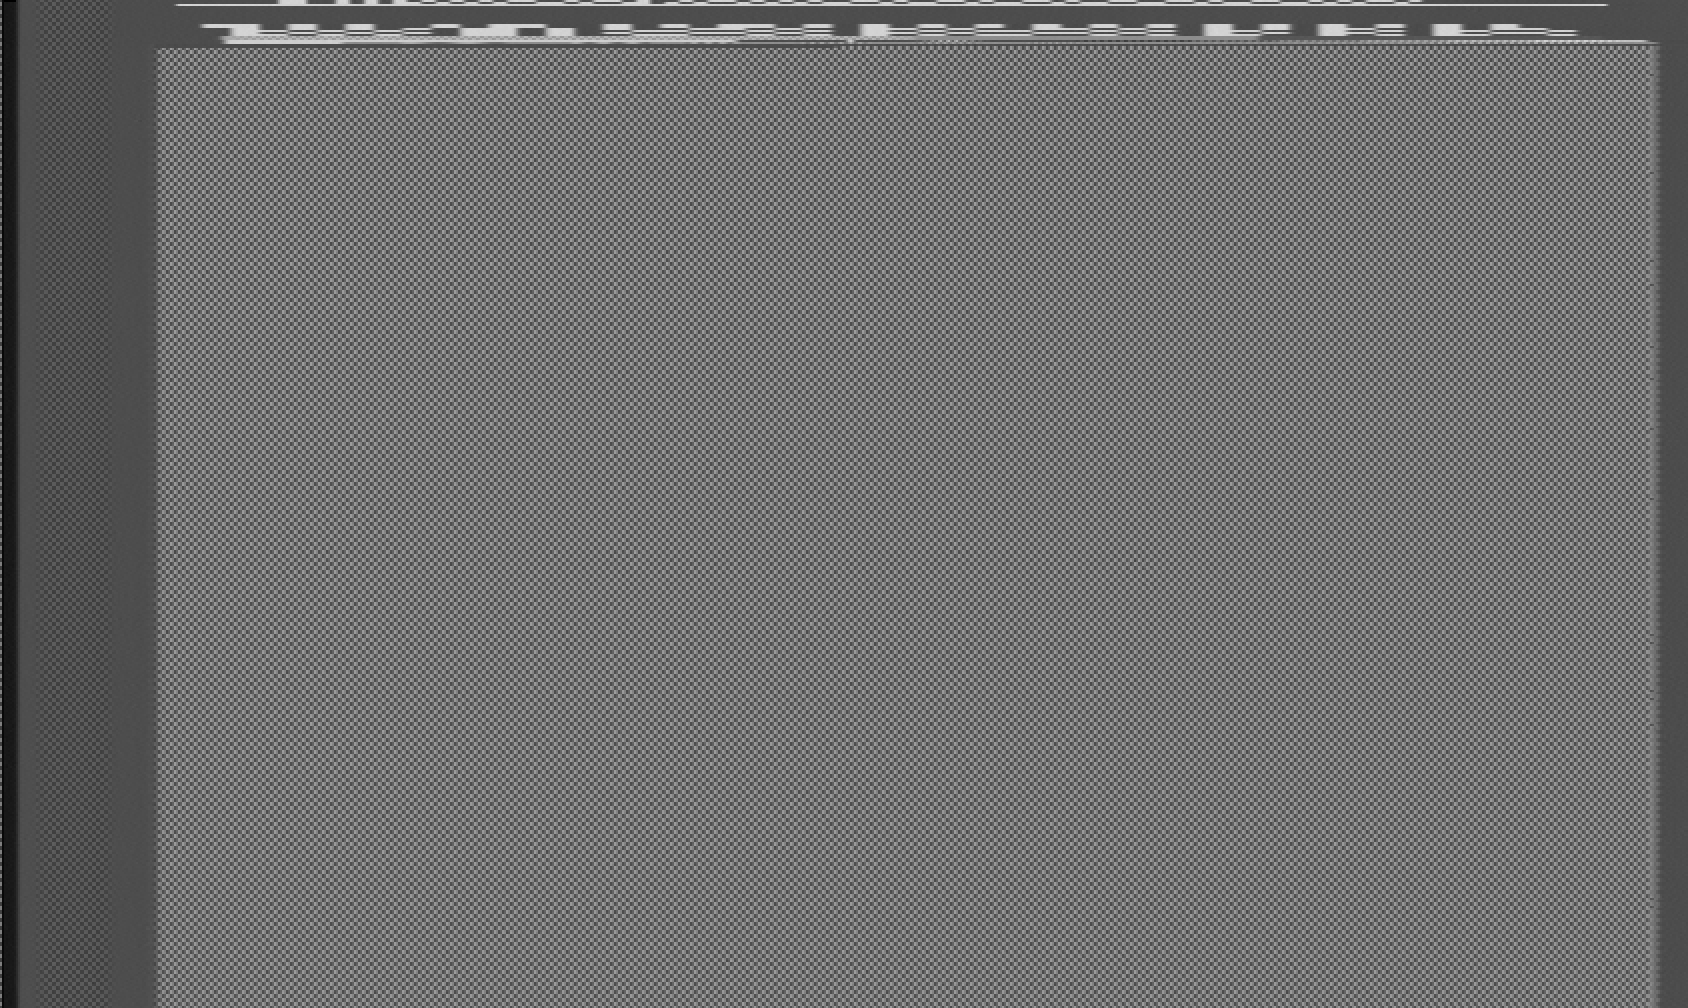

In [150]:
drawdata(output_cropped, 844, 504, hscale=2, vscale=2)

(425376,)
uint8 (504, 844) (504, 844)


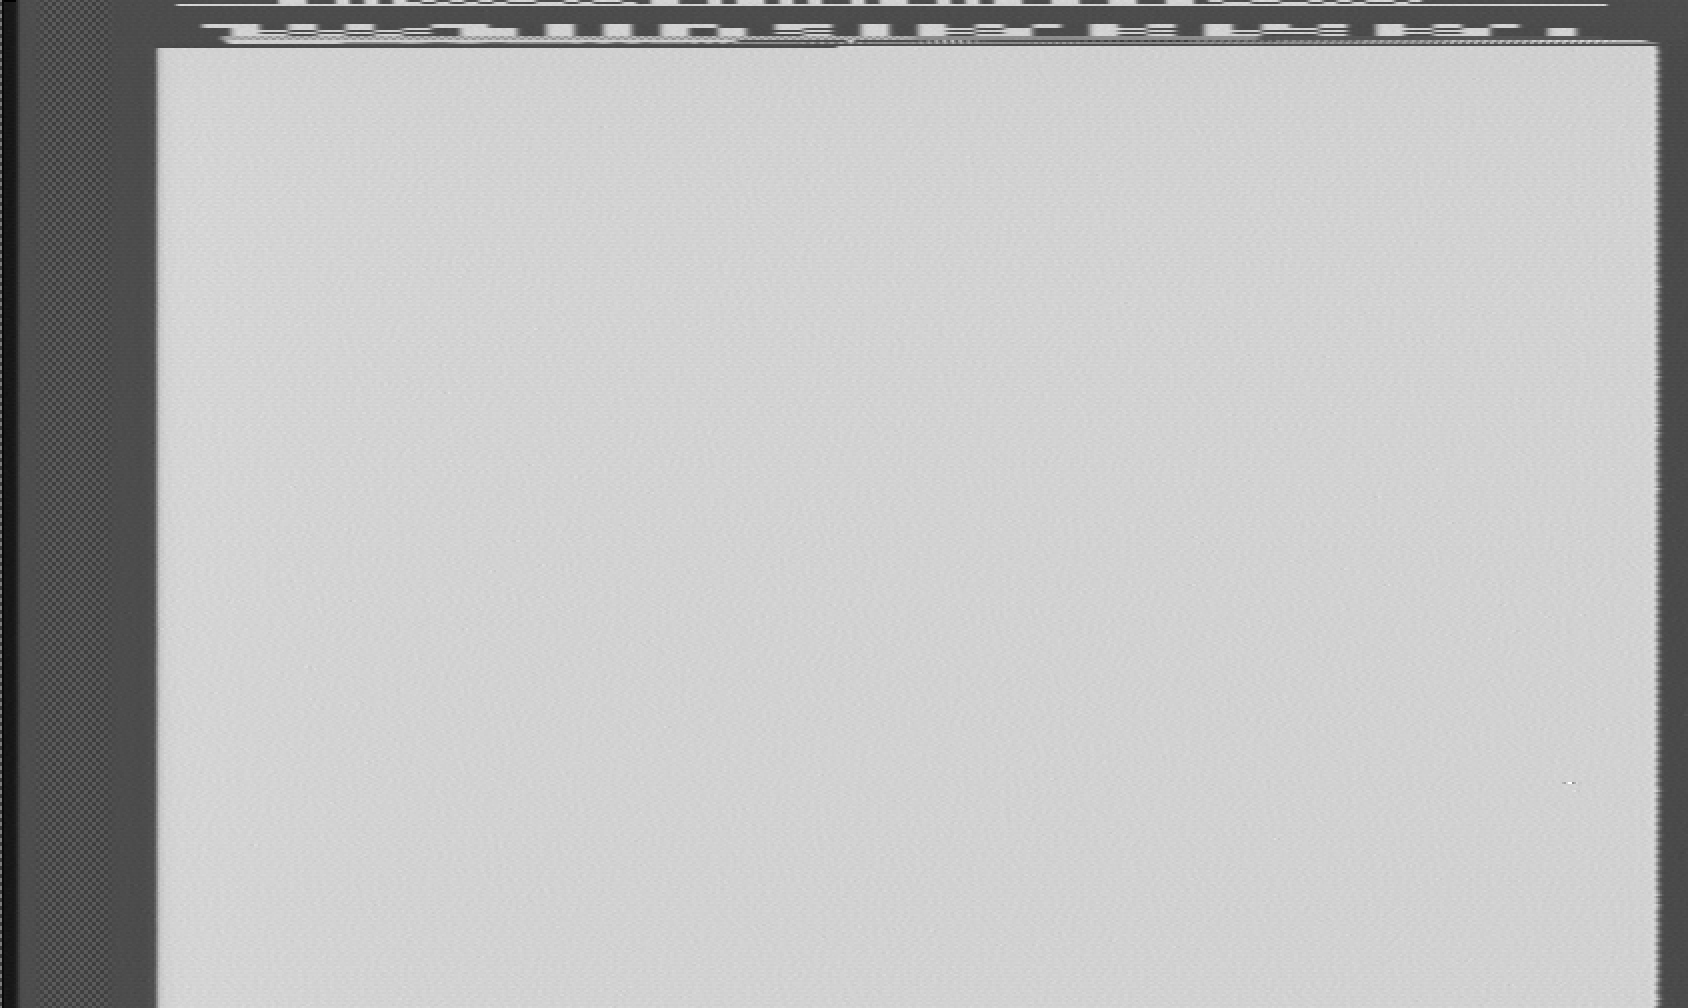

In [51]:
drawdata(output_cropped, 844, 504, hscale=2, vscale=2)